In [1]:
import torch
import random
import subprocess
import numpy as np
from tqdm import tqdm
from scipy import stats
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse
import pandas as pd
import seaborn as sns
import matplotlib
import os

In [2]:
def replace_conditions(adata):
    adata.obs["condition"].replace("CD4T_ctrl", "CD4-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD4T_real_stim", "CD4-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD4T_pred_stim", "CD4-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD8T_ctrl", "CD8-T_ctrl", inplace=True)
    adata.obs["condition"].replace("CD8T_real_stim", "CD8-T_real_stim", inplace=True)
    adata.obs["condition"].replace("CD8T_pred_stim", "CD8-T_pred_stim", inplace=True)

    adata.obs["condition"].replace("Dendritic_ctrl", "DC_ctrl", inplace=True)
    adata.obs["condition"].replace("Dendritic_real_stim", "DC_real_stim", inplace=True)
    adata.obs["condition"].replace("Dendritic_pred_stim", "DC_pred_stim", inplace=True)

    adata.obs["condition"].replace("FCGR3A+Mono_ctrl", "F-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_real_stim", "F-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("FCGR3A+Mono_pred_stim", "F-Mono_pred_stim", inplace=True)

    adata.obs["condition"].replace("CD14+Mono_ctrl", "CD14-Mono_ctrl", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_real_stim", "CD14-Mono_real_stim", inplace=True)
    adata.obs["condition"].replace("CD14+Mono_pred_stim", "CD14-Mono_pred_stim", inplace=True)
def replace_cell_types(adata):
    adata.obs["cell_type"].replace("CD4T", "CD4-T", inplace=True)
    adata.obs["cell_type"].replace("CD8T", "CD8-T", inplace=True)
    adata.obs["cell_type"].replace("Dendritic", "DC", inplace=True)
    adata.obs["cell_type"].replace("FCGR3A+Mono", "F-Mono", inplace=True)
    adata.obs["cell_type"].replace("CD14+Mono", "CD14-Mono", inplace=True)

In [3]:
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2., 1.01 * height,
                '%.2f' % float(height),
                ha='center', va='bottom', fontsize=18)

In [4]:
def adata2numpy(adata):
    if sparse.issparse(adata.X):
        return adata.X.A
    else:
        return adata.X

In [5]:
def grouped_barplot(df, cat, subcat, val, err, filename, put_label=False, legend=False, offset=0.375, data_name = 'pbmc'):
    plt.close("all")
#     import matplotlib
    matplotlib.rc('ytick', labelsize=25)
    matplotlib.rc('xtick', labelsize=30)
    u = df[cat].unique()
    x_pos = np.arange(0, 2*len(u), 2)
    subx = df[subcat].unique()
    plt.figure(figsize=(12, 10))
#     g = sns.catplot(x=cat, y=val, hue=subcat, data=df, kind='bar', palette="muted", height=6, legend=False)
#     g.despine(left=True)
#     plt.yticks(np.arange(0, 1.2, 0.2))
#     g.set_xticklabels(rotation=90)
#     g.set_xlabels("")
    for i, gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        b = plt.bar(x_pos + i/1.25, dfg[val].values, capsize=10, alpha=0.95, label=f"{gr}", yerr=dfg[err].values)
        a=np.random.normal(dfg[val].values, dfg[err].values, (10, len(u)))
#         print(a.shape)
#         dfc=pd.DataFrame({'x': x_pos + i/1.25, 'y': a[0]})
        plt.plot(x_pos + i/1.25, a.T, '.', color='black', alpha=0.5)
        if put_label:
            autolabel(b)
    plt.title(f"{data_name}_bar_plot")
    plt.ylabel(r"$\mathrm{R^2}$", fontsize=25)
    plt.xticks(x_pos+offset, u, rotation=90)
    plt.grid(False)
    if legend:
        plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left", borderaxespad=0, prop={'size': 18})
    plt.tight_layout()
    # plt.savefig(os.path.join('figures', filename), dpi=300)
    plt.show()

In [6]:
def calc_R2_specific_model(adata, n_genes, conditions):
    if n_genes != adata.shape[1]:
        sc.tl.rank_genes_groups(adata, groupby="condition", n_genes=n_genes, method="wilcoxon")
        diff_genes = adata.uns["rank_genes_groups"]["names"][conditions["real_stim"]]
        adata = adata[:, diff_genes.tolist()]
    r2_means, r2_vars = [], []
    r_values = np.zeros((1, 100))
    real_stim = adata[adata.obs["condition"] == conditions["real_stim"]]
    pred_stim = adata[adata.obs["condition"] == conditions["pred_stim"]]
    pred_stim = adata2numpy(pred_stim)
    real_stim = adata2numpy(real_stim)
#     print(adata.obs['condition'])
#     print(conditions)
#     print(pred_stim)
#     print(real_stim)
#     for i in range(100):
#         pred_stim_idx = np.random.choice(range(0, pred_stim.shape[0]), int(0.8 * pred_stim.shape[0]))
#         real_stim_idx = np.random.choice(range(0, real_stim.shape[0]), int(0.8 * real_stim.shape[0]))
    x = np.average(pred_stim, axis=0)
    y = np.average(real_stim, axis=0)
    m, b, r_value, p_value, std_err = stats.linregress(x, y)
#     print(r_value)
    r_values = r_value ** 2
#     print(r_values.mean(), r_values.std())
    return r_values.mean(), r_values.std()

In [7]:
names = {
    "pbmc": ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK'],
    "hpoly": ['Endocrine', 'Enterocyte', 'Enterocyte.Progenitor', 'Goblet', 'Stem', 'TA', 'TA.Early'],
    "study": ['B', 'CD4T', 'CD8T', 'CD14+Mono', 'Dendritic', 'FCGR3A+Mono', 'NK'],
}
keys = {
    "pbmc": ['stimulated', 'control', 'pred', 'cell_type'],
    "hpoly": ['Hpoly.Day10', 'Control', 'pred', 'cell_label'],
    "study": ['stimulated', 'control', 'pred', 'cell_type'],
}

In [8]:
scperb_all_data = {
    "pbmc": sc.read("../all_data/scperb_pbmc_all_data.h5ad"),
    "hpoly": sc.read("../all_data/scperb_hpoly_all_data.h5ad"),
    "study": sc.read("../all_data/scperb_study_all_data.h5ad"),
}

scgen_all_data = {
    "pbmc": sc.read("../all_data/scgen_pbmc_all_data.h5ad"),
    "hpoly": sc.read("../all_data/scgen_hpoly_all_data.h5ad"),
    "study": sc.read("../all_data/scgen_study_all_data.h5ad"),
}

CVAE_all_data = {
    "pbmc": sc.read("../all_data/CVAE_pbmc_all_data.h5ad"),
    "hpoly": sc.read("../all_data/CVAE_hpoly_all_data.h5ad"),
    "study": sc.read("../all_data/CVAE_study_all_data.h5ad"),
}

STGAN_all_data = {
    "pbmc": sc.read("../all_data/STGAN_pbmc_all_data.h5ad"),
    "hpoly": sc.read("../all_data/STGAN_hpoly_all_data.h5ad"),
    "study": sc.read("../all_data/STGAN_study_all_data.h5ad"),
}

WGAN_all_data = {
    "pbmc": sc.read("../all_data/WGAN_pbmc_all_data.h5ad"),
    "hpoly": sc.read("../all_data/WGAN_hpoly_all_data.h5ad"),
    "study": sc.read("../all_data/WGAN_study_all_data.h5ad"),
}

valid = {
    "pbmc": sc.read("../../data/valid_pbmc.h5ad"),
    "hpoly": sc.read("../../data/valid_hpoly.h5ad"),
    "study": sc.read("../../data/valid_study.h5ad"),
}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Library/Fra

In [9]:
def get_cell_type_data(cell_type, name):
    ctrl = valid[name][(valid[name].obs[keys[name][3]] == cell_type) & (valid[name].obs['condition'] == keys[name][1])]
    stim = valid[name][(valid[name].obs[keys[name][3]] == cell_type) & (valid[name].obs['condition'] == keys[name][0])]
    scperb_pred = scperb_all_data[name][(scperb_all_data[name].obs[keys[name][3]] == cell_type) & (scperb_all_data[name].obs['condition'] == "pred")]
    scgen_pred = scgen_all_data[name][(scgen_all_data[name].obs[keys[name][3]] == cell_type) & (scgen_all_data[name].obs['condition'] == "pred")]
    CVAE_pred = CVAE_all_data[name][(CVAE_all_data[name].obs[keys[name][3]] == cell_type) & (CVAE_all_data[name].obs['condition'] == "pred")]
    STGAN_pred = STGAN_all_data[name][(STGAN_all_data[name].obs[keys[name][3]] == cell_type) & (STGAN_all_data[name].obs['condition'] == "pred")]
    WGAN_pred = WGAN_all_data[name][(WGAN_all_data[name].obs[keys[name][3]] == cell_type) & (WGAN_all_data[name].obs['condition'] == "pred")]
    scperb_pred.obs['condition'] = "scperb"
    scgen_pred.obs['condition'] = "scgen"
    CVAE_pred.obs['condition'] = "CVAE"
    STGAN_pred.obs['condition'] = "STGAN"
    WGAN_pred.obs['condition'] = "WGAN"
    ctrl.obs['condition'] = "control"
    stim.obs['condition'] = "real"
    all_data = ctrl.concatenate(stim, scperb_pred, scgen_pred, CVAE_pred, STGAN_pred, WGAN_pred)
    return all_data

In [10]:
def get_cell_type_df(cell_type, name):
    ctrl = valid[name][(valid[name].obs[keys[name][3]] == cell_type) & (valid[name].obs['condition'] == keys[name][1])]
    stim = valid[name][(valid[name].obs[keys[name][3]] == cell_type) & (valid[name].obs['condition'] == keys[name][0])]
    
    scperb_pred = scperb_all_data[name][(scperb_all_data[name].obs[keys[name][3]] == cell_type)]
    scgen_pred = scgen_all_data[name][(scgen_all_data[name].obs[keys[name][3]] == cell_type)]
    CVAE_pred = CVAE_all_data[name][(CVAE_all_data[name].obs[keys[name][3]] == cell_type)]
    STGAN_pred = STGAN_all_data[name][(STGAN_all_data[name].obs[keys[name][3]] == cell_type)]
    WGAN_pred = WGAN_all_data[name][(WGAN_all_data[name].obs[keys[name][3]] == cell_type)]
    
#     scperb_pred.obs['condition'] = "scperb"
#     scgen_pred.obs['condition'] = "scgen"
#     CVAE_pred.obs['condition'] = "CVAE"
#     STGAN_pred.obs['condition'] = "STGAN"
#     WGAN_pred.obs['condition'] = "WGAN"
    
    conditions = {"real_stim": keys[name][0], "pred_stim": "pred"}
    CVAE_r2_mean, CVAE_r2_var = calc_R2_specific_model(CVAE_pred, n_genes=6998, conditions=conditions)
    WGAN_r2_mean, WGAN_r2_var = calc_R2_specific_model(WGAN_pred, n_genes=6998, conditions=conditions)
    STGAN_r2_mean, STGAN_r2_var = calc_R2_specific_model(STGAN_pred, n_genes=6998, conditions=conditions)
    scgen_r2_mean, scgen_r2_var = calc_R2_specific_model(scgen_pred, n_genes=6998, conditions=conditions)
    scperb_r2_mean, scperb_r2_var = calc_R2_specific_model(scperb_pred, n_genes=6998, conditions=conditions)
    
    all_means = np.array([scperb_r2_mean, scgen_r2_mean, CVAE_r2_mean, STGAN_r2_mean, WGAN_r2_mean])
    all_vars = np.array([scperb_r2_var, scgen_r2_var, CVAE_r2_var, STGAN_r2_var, WGAN_r2_var])
    all_types = ["All genes"] * 5
    models = ["scperb", "scgen", "CVAE", "STGAN", "WGAN", ]
    df = pd.DataFrame({"R^2 Means": all_means, "R^2 Stddevs": all_vars, "Type": all_types, "Models": models})
    return df

In [11]:
def plot_bar(cell_type, name):
    font = {'family' : 'Arial',
        'size'   : 10}
    df = get_cell_type_df(cell_type, name)
    matplotlib.rc('font', **font)
    matplotlib.rc('ytick', labelsize=20)
    matplotlib.rc('xtick', labelsize=20)
    grouped_barplot(df, "Models", "Type", "R^2 Means", "R^2 Stddevs", put_label=True, legend=False, filename=f"{name}_{cell_type}_models_barplots.pdf", offset=0.0, data_name = f'{name}_{cell_type}')

In [12]:
def plot_all_cell_type_bar_garph(name):
    for cell_type in names[name]:
        plot_bar(cell_type, name)

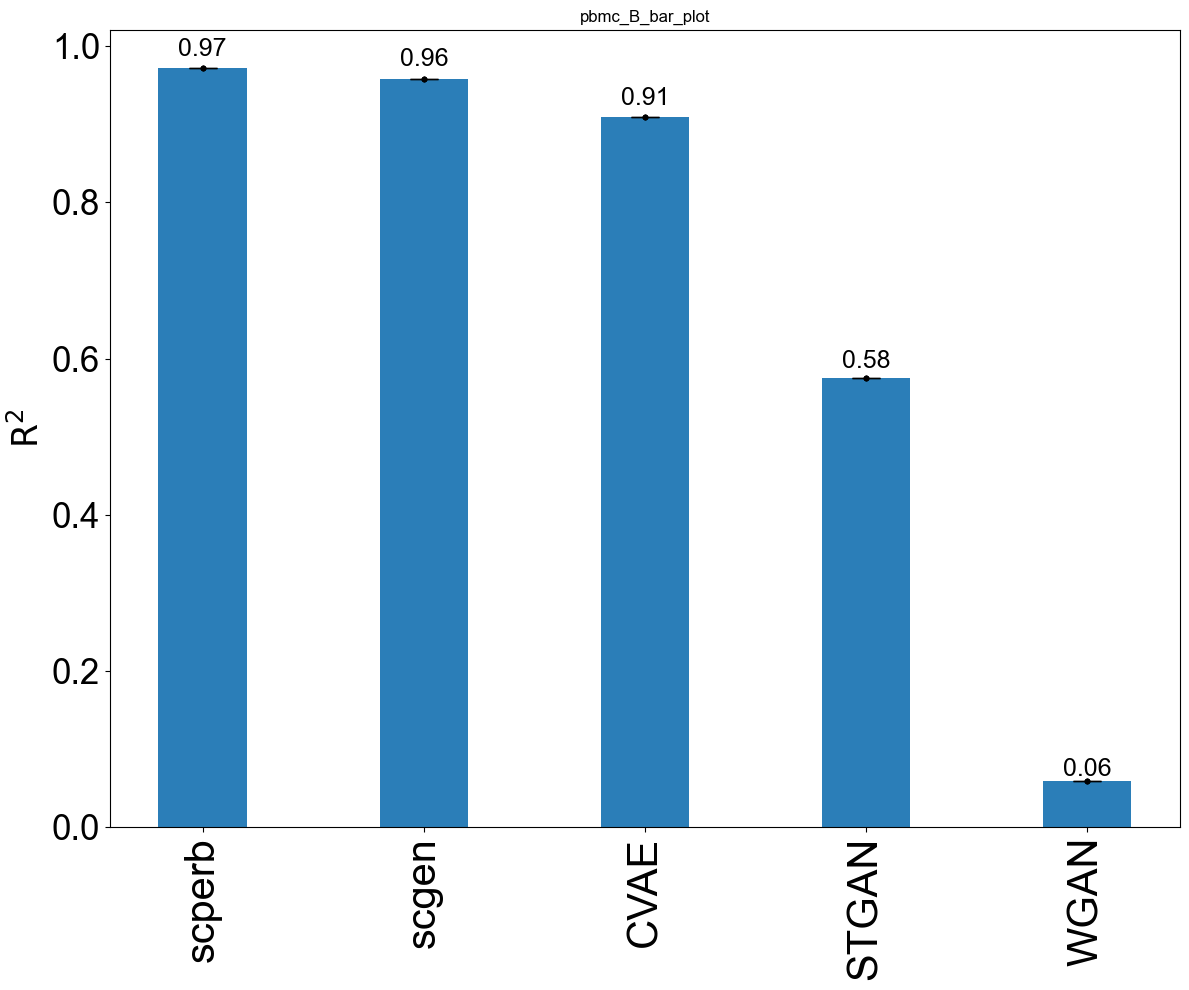

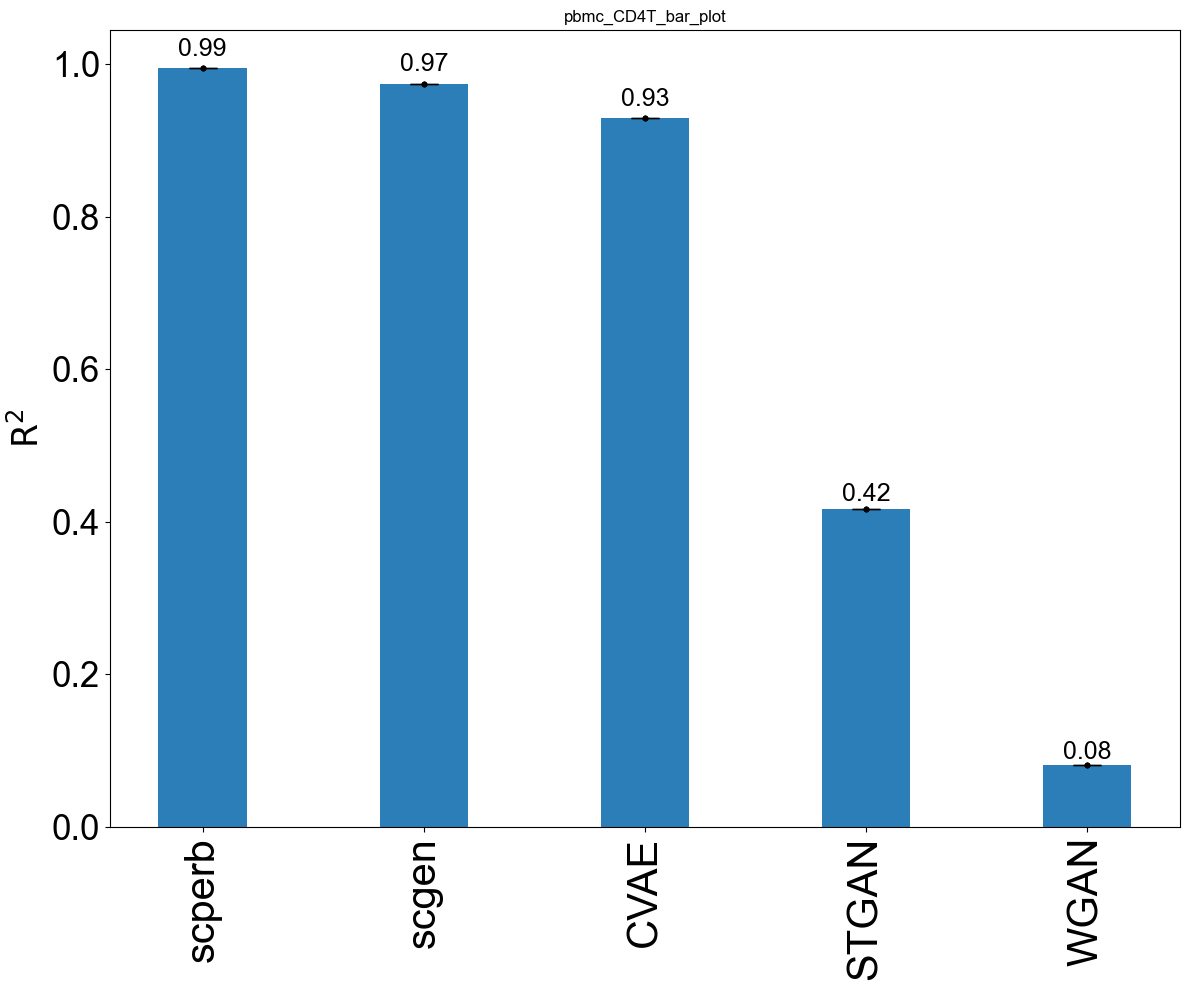

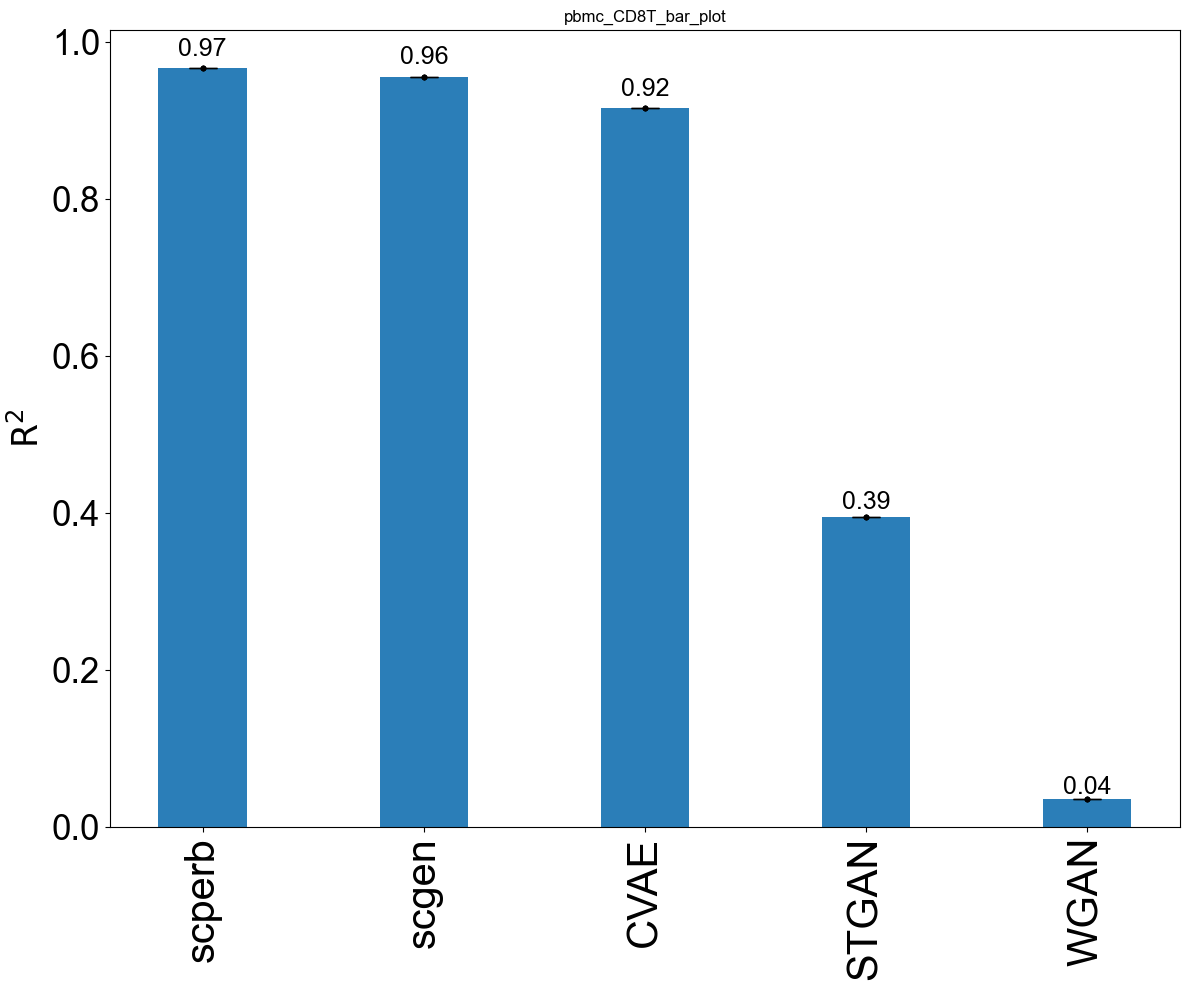

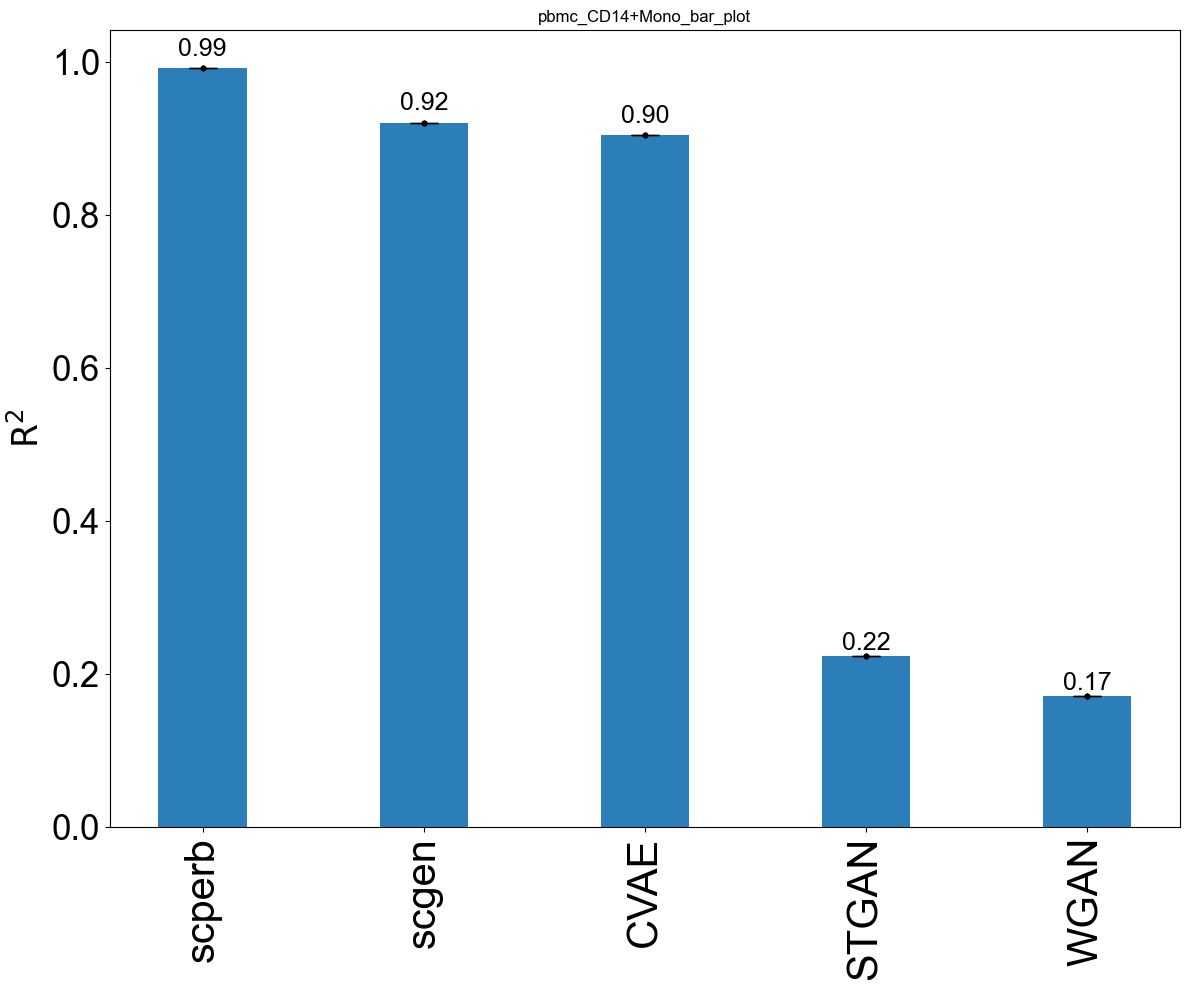

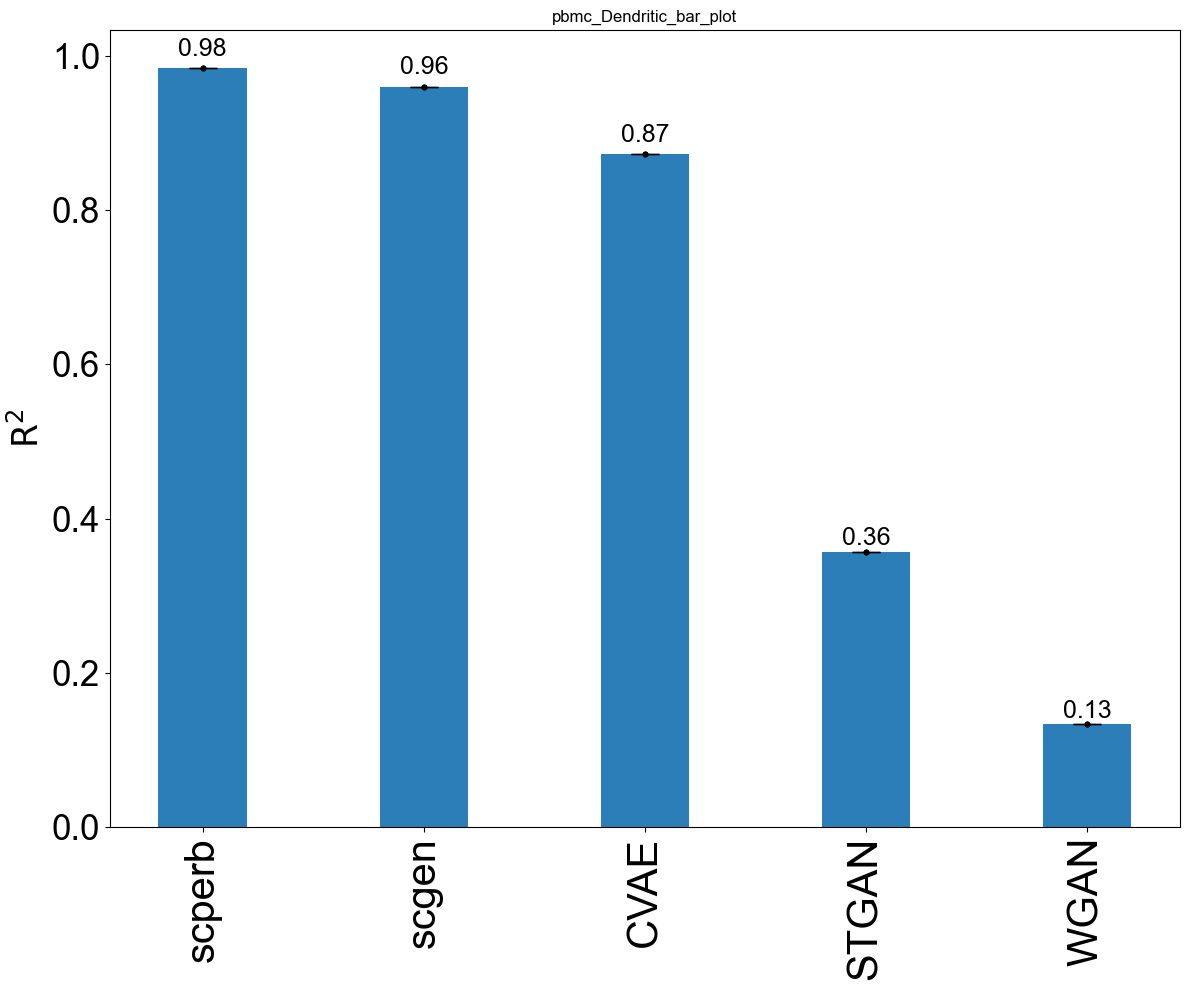

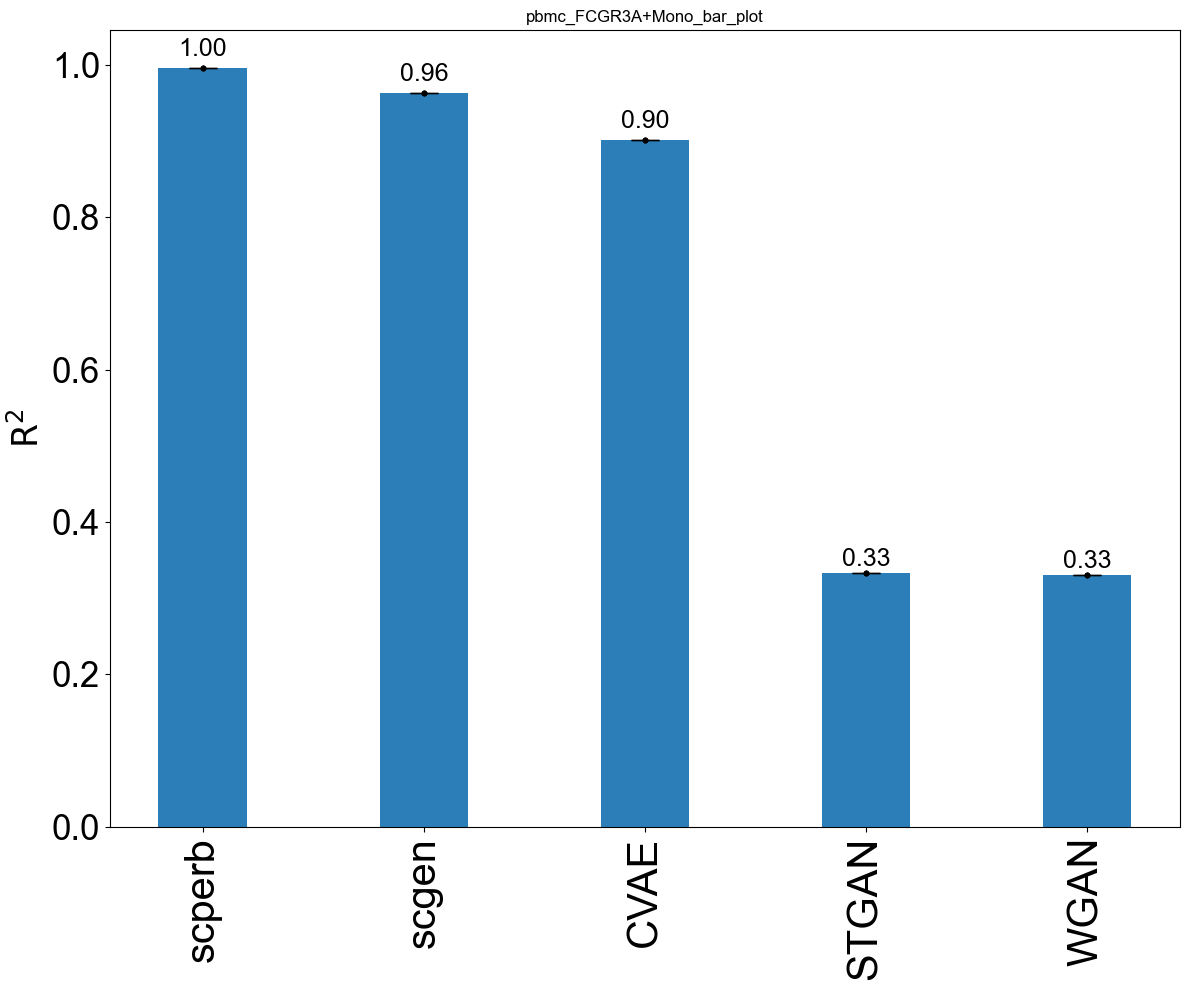

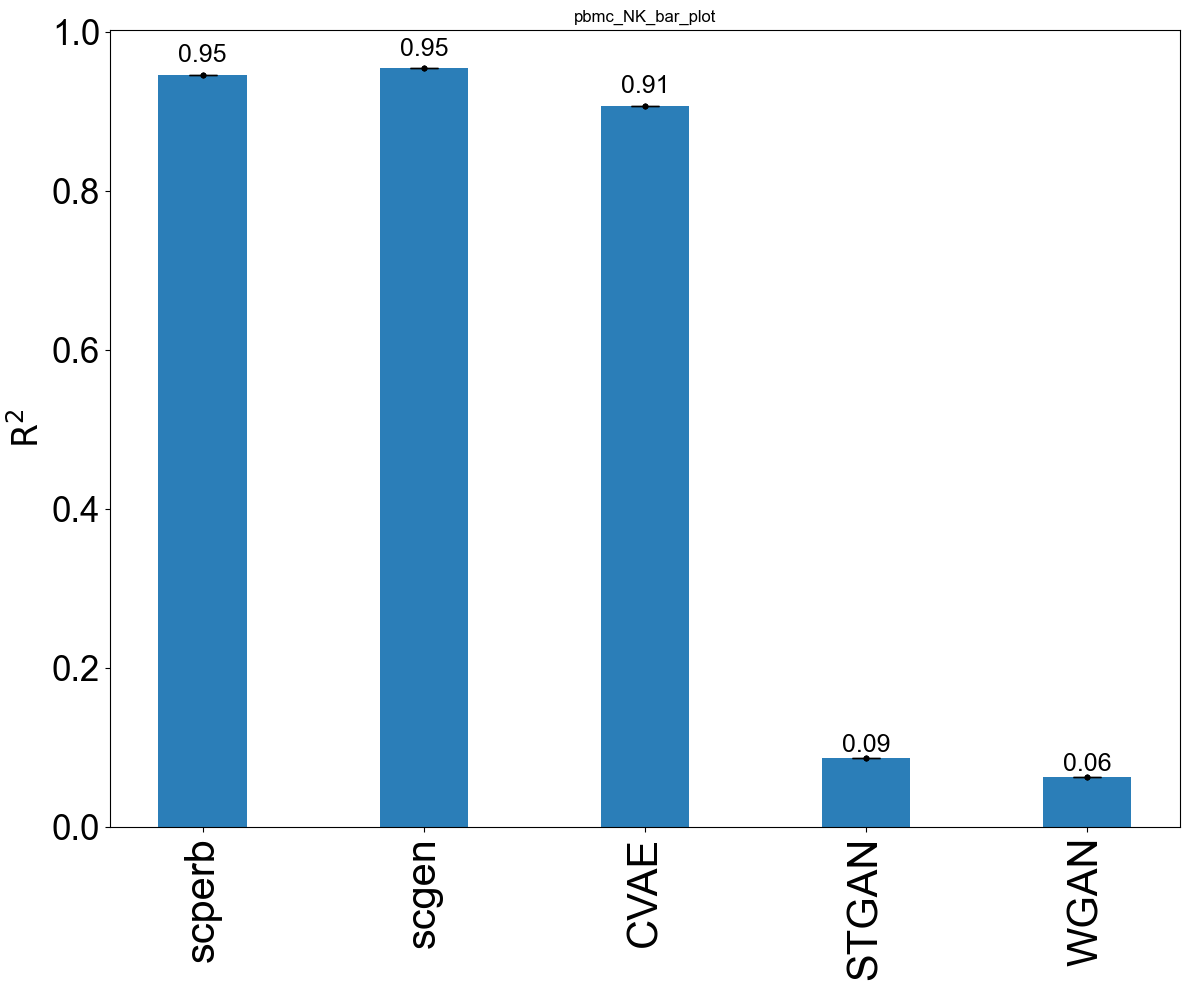

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

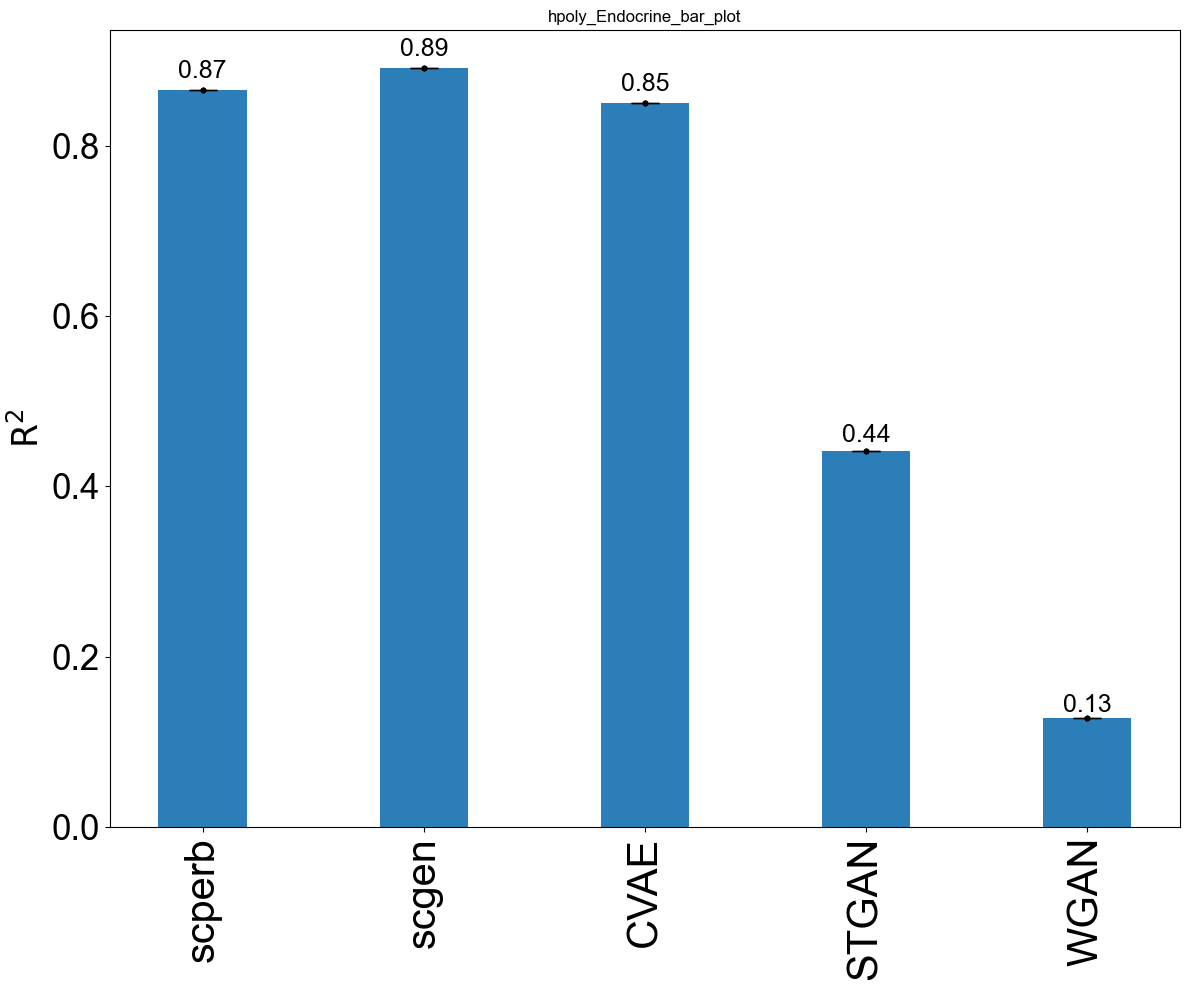

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

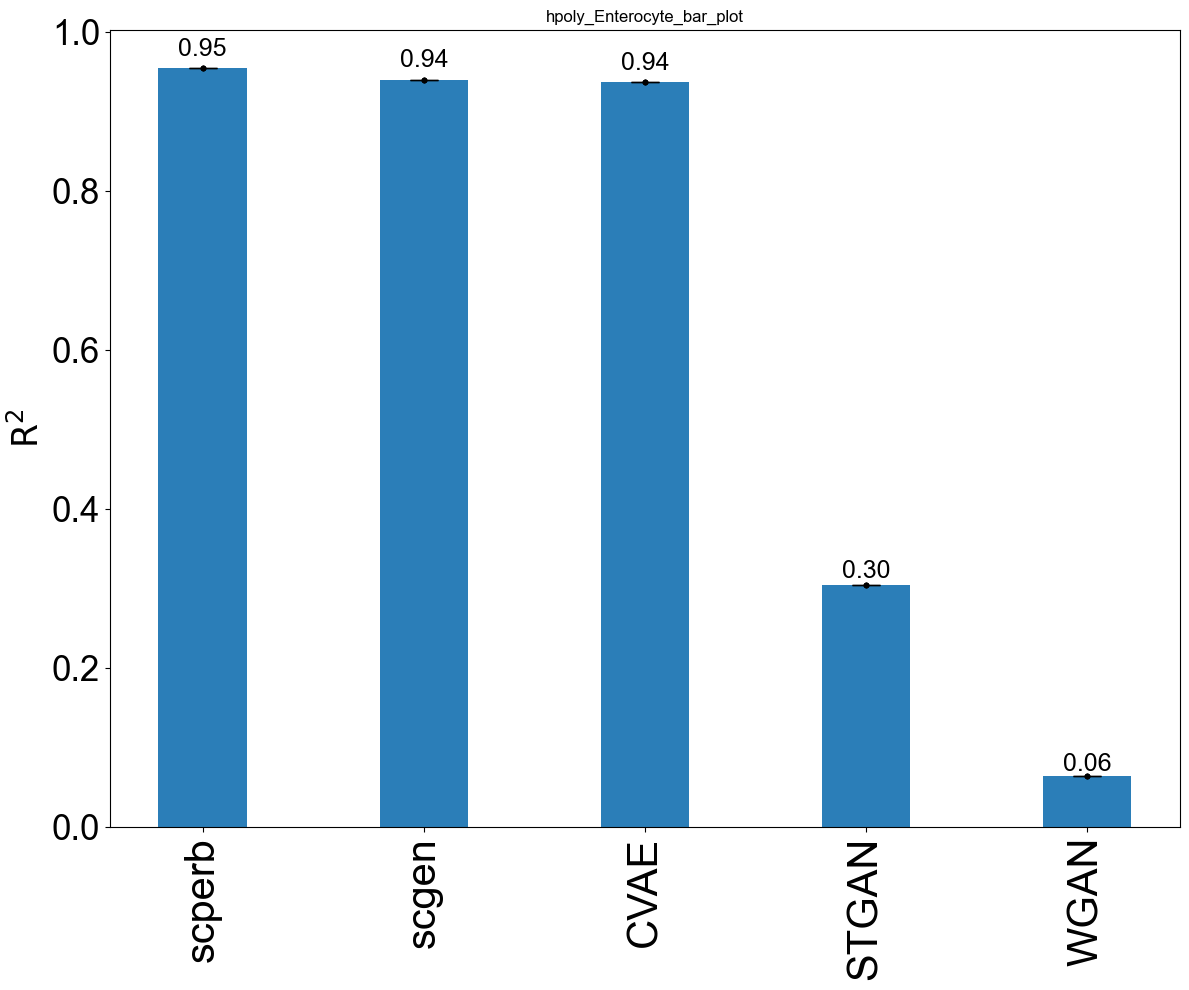

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

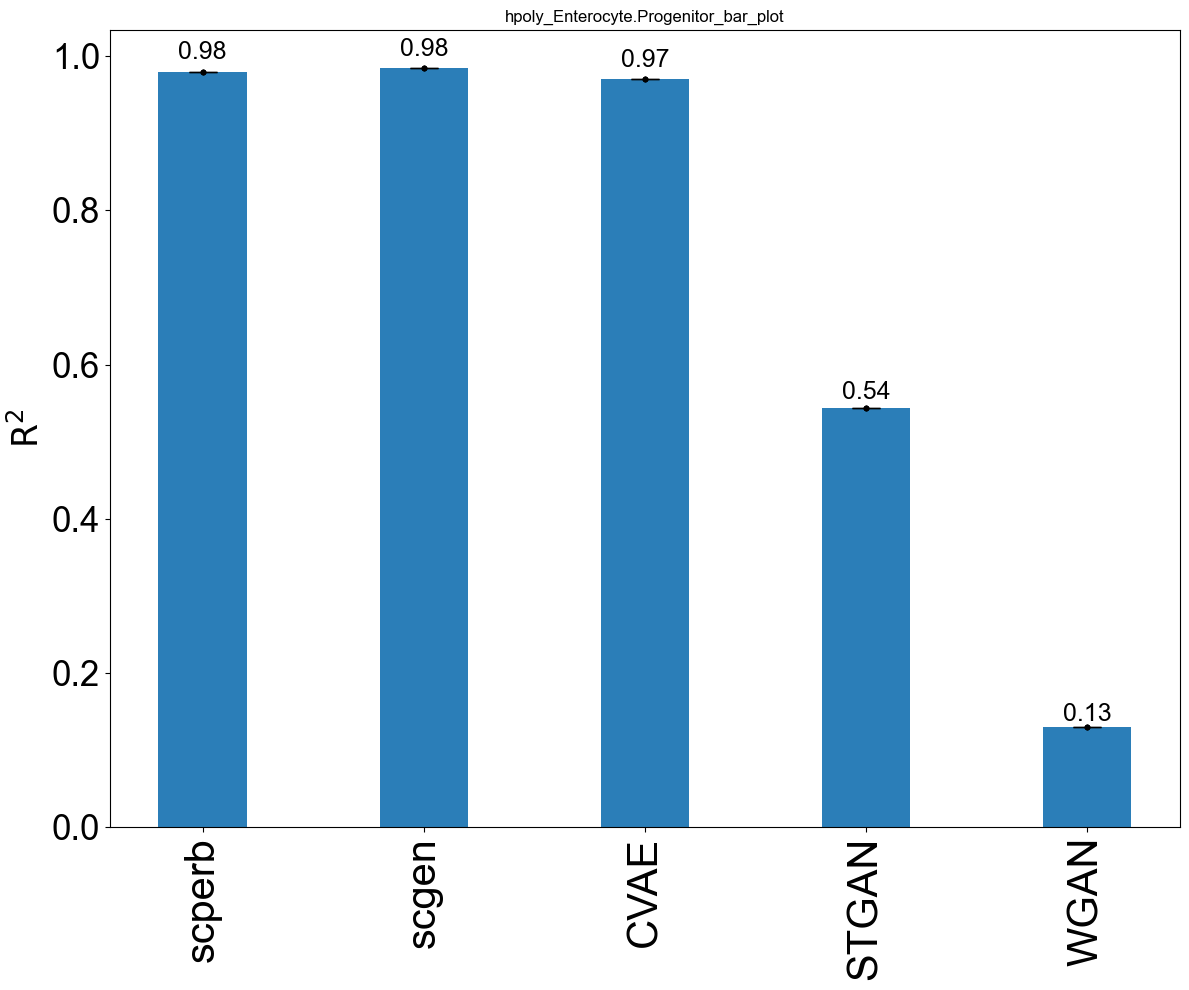

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

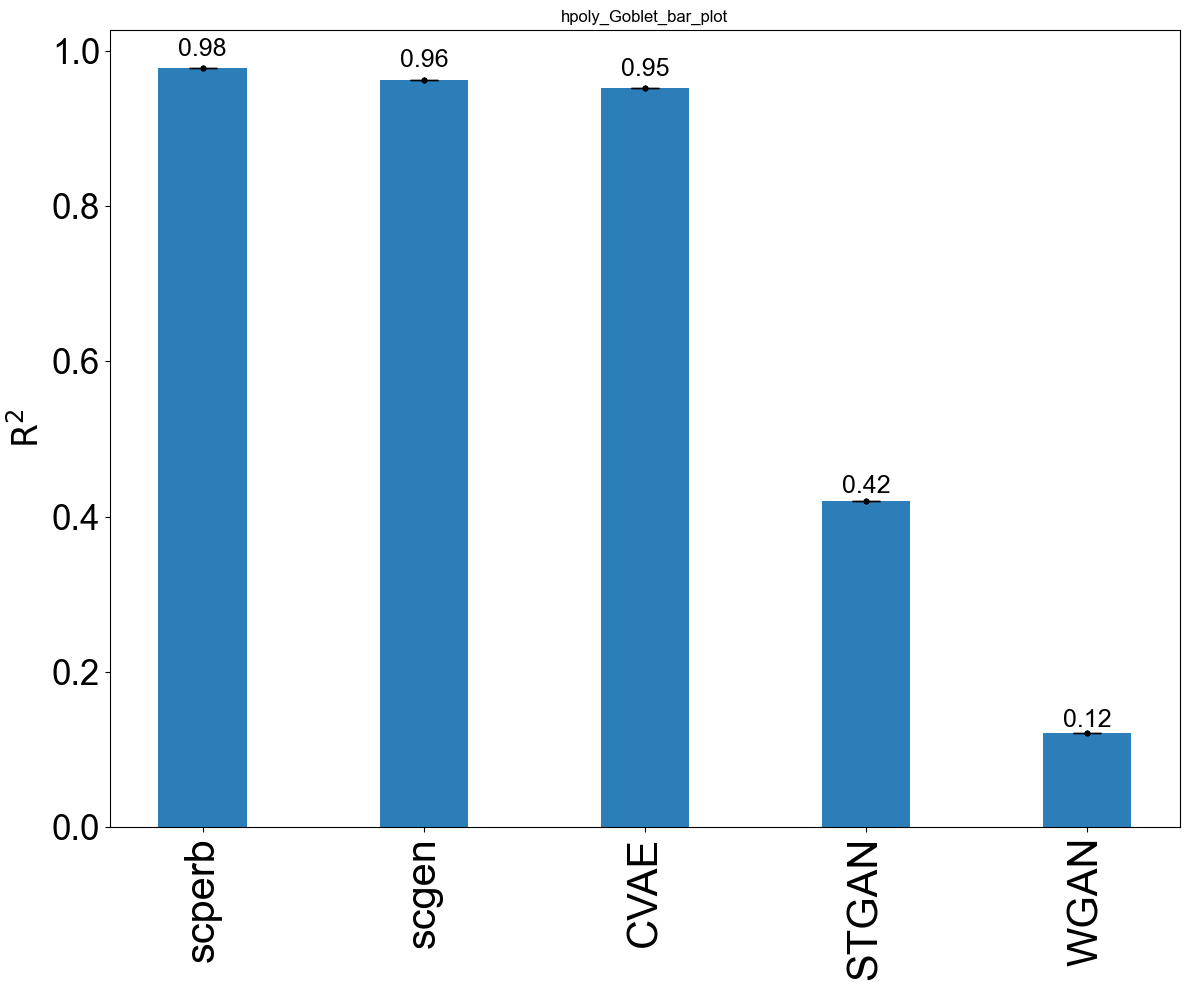

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

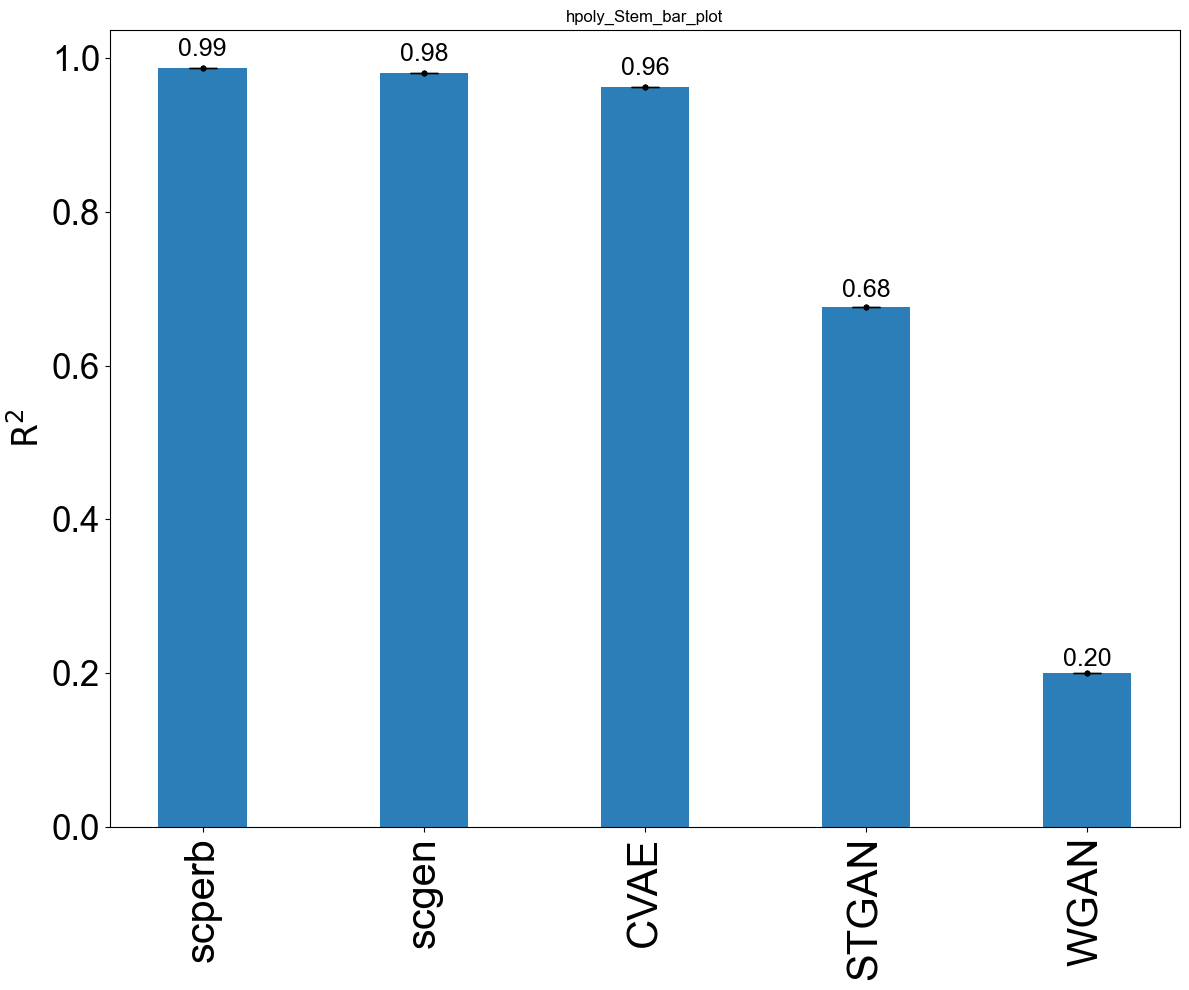

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

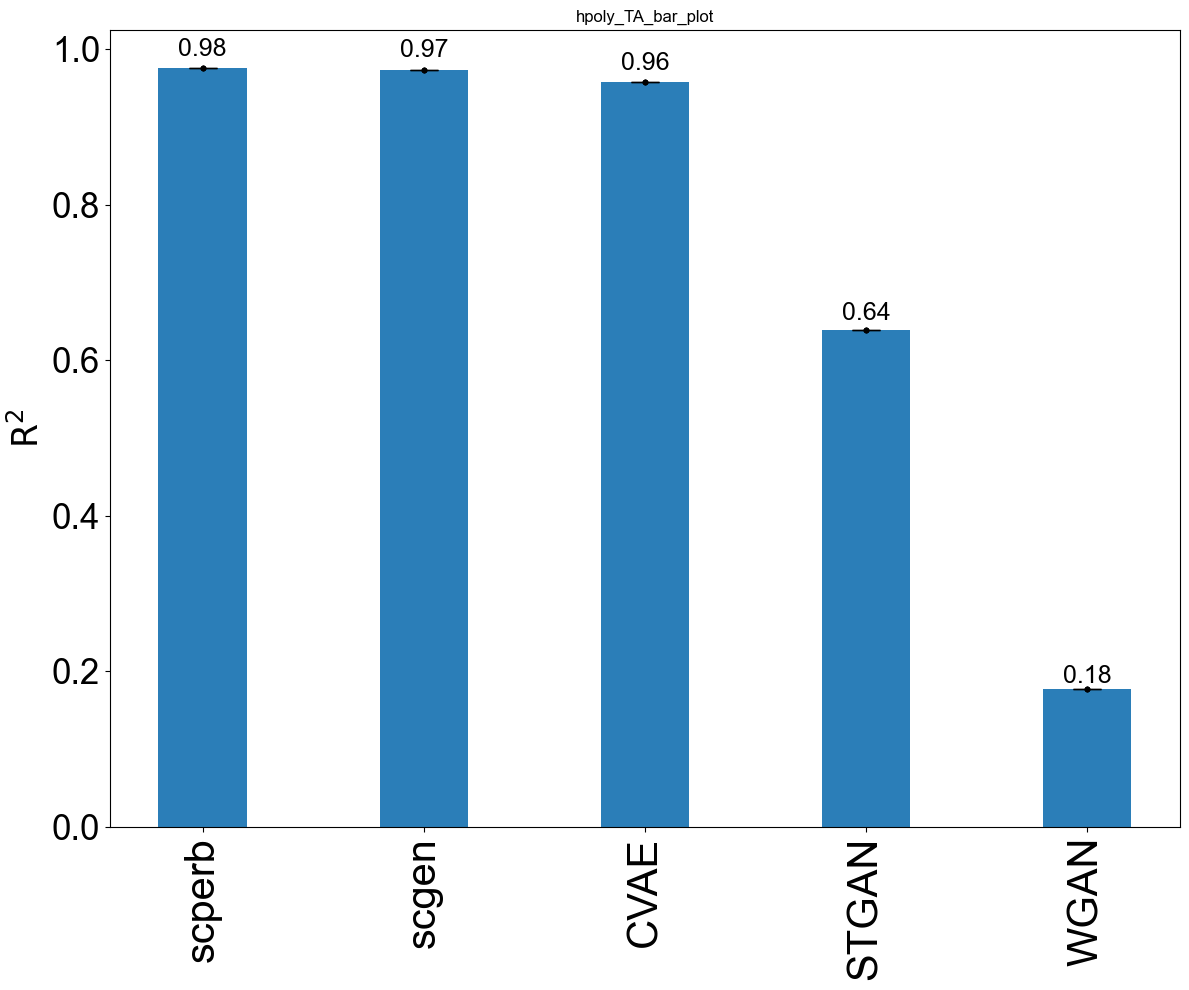

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

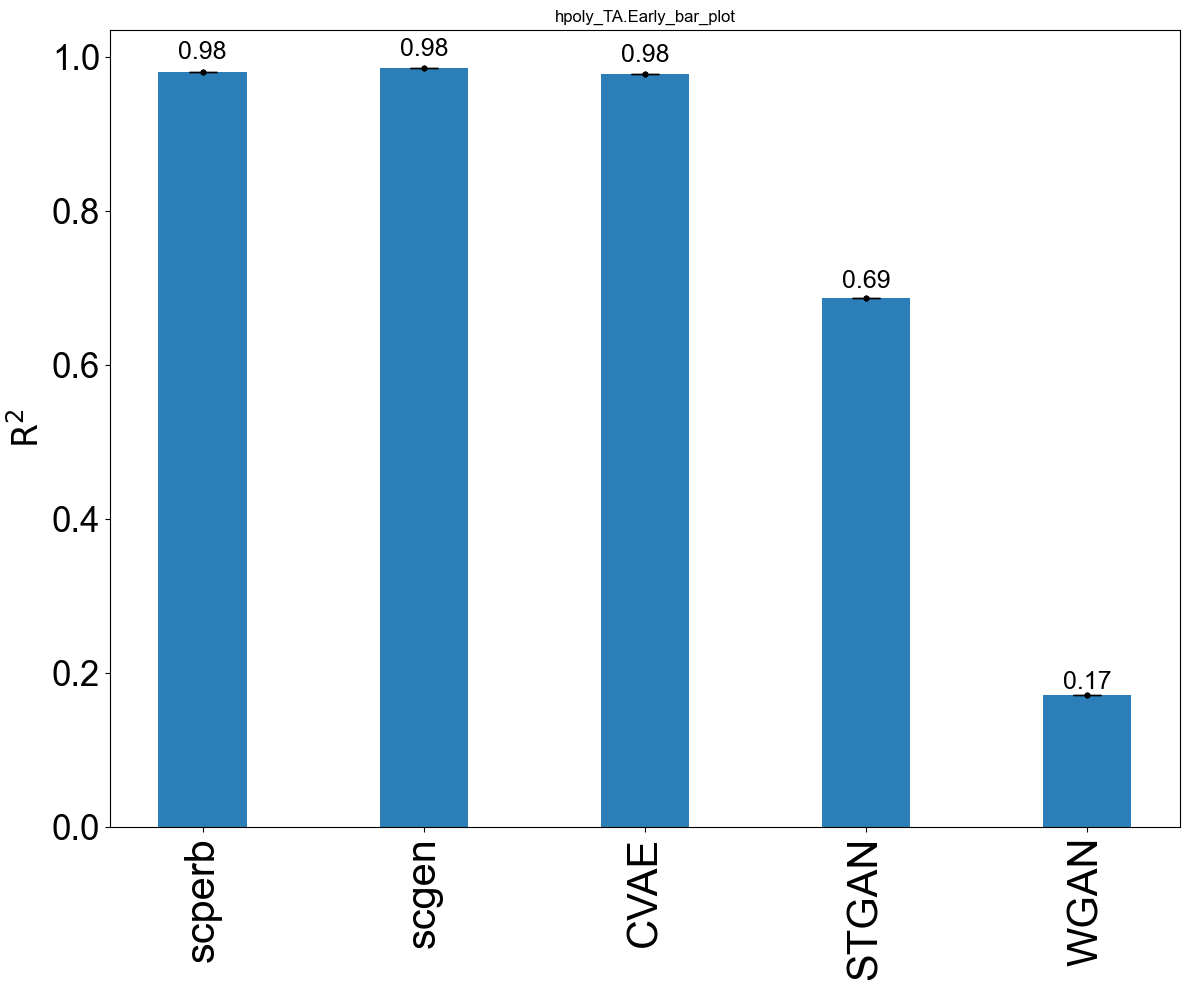

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

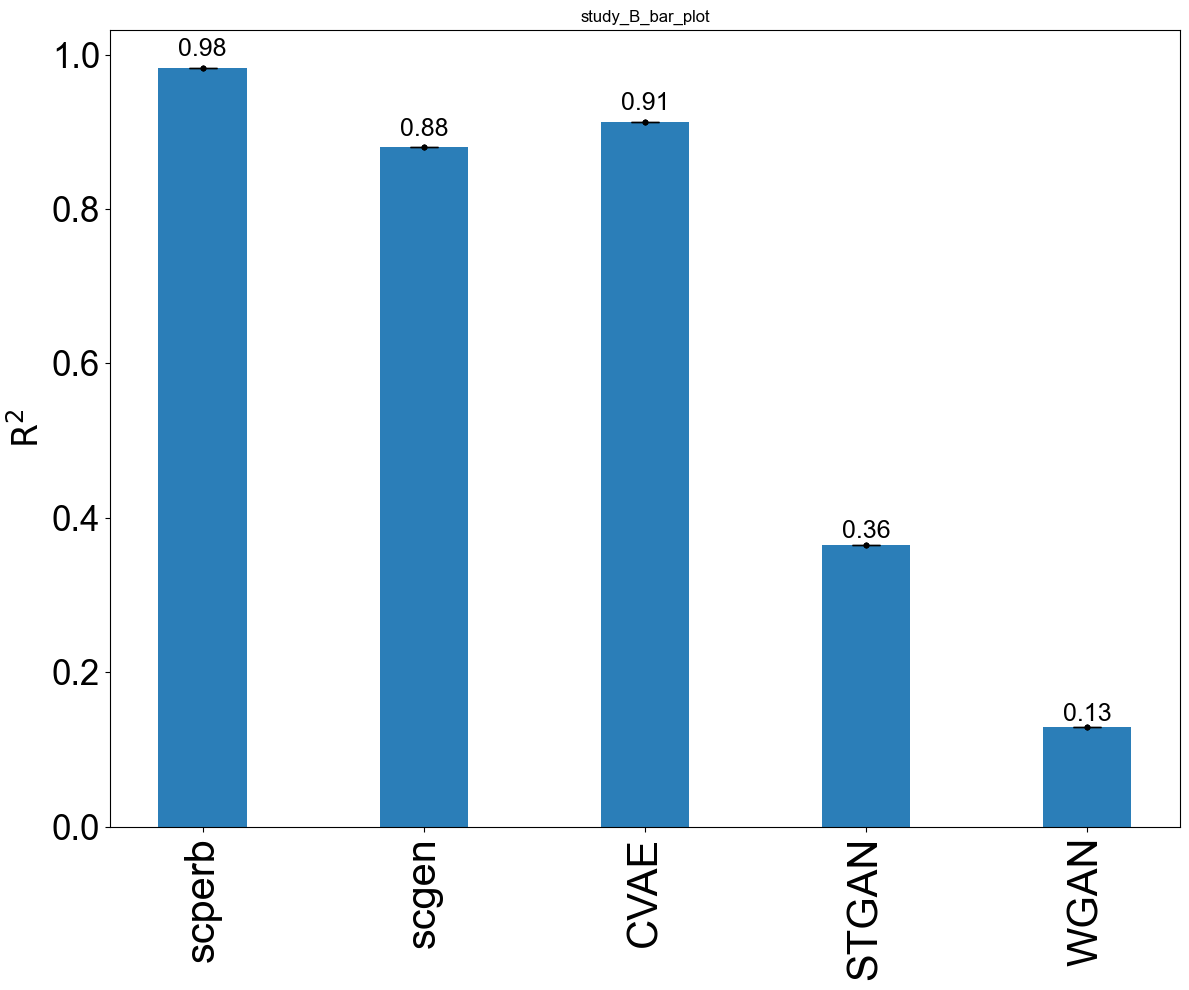

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

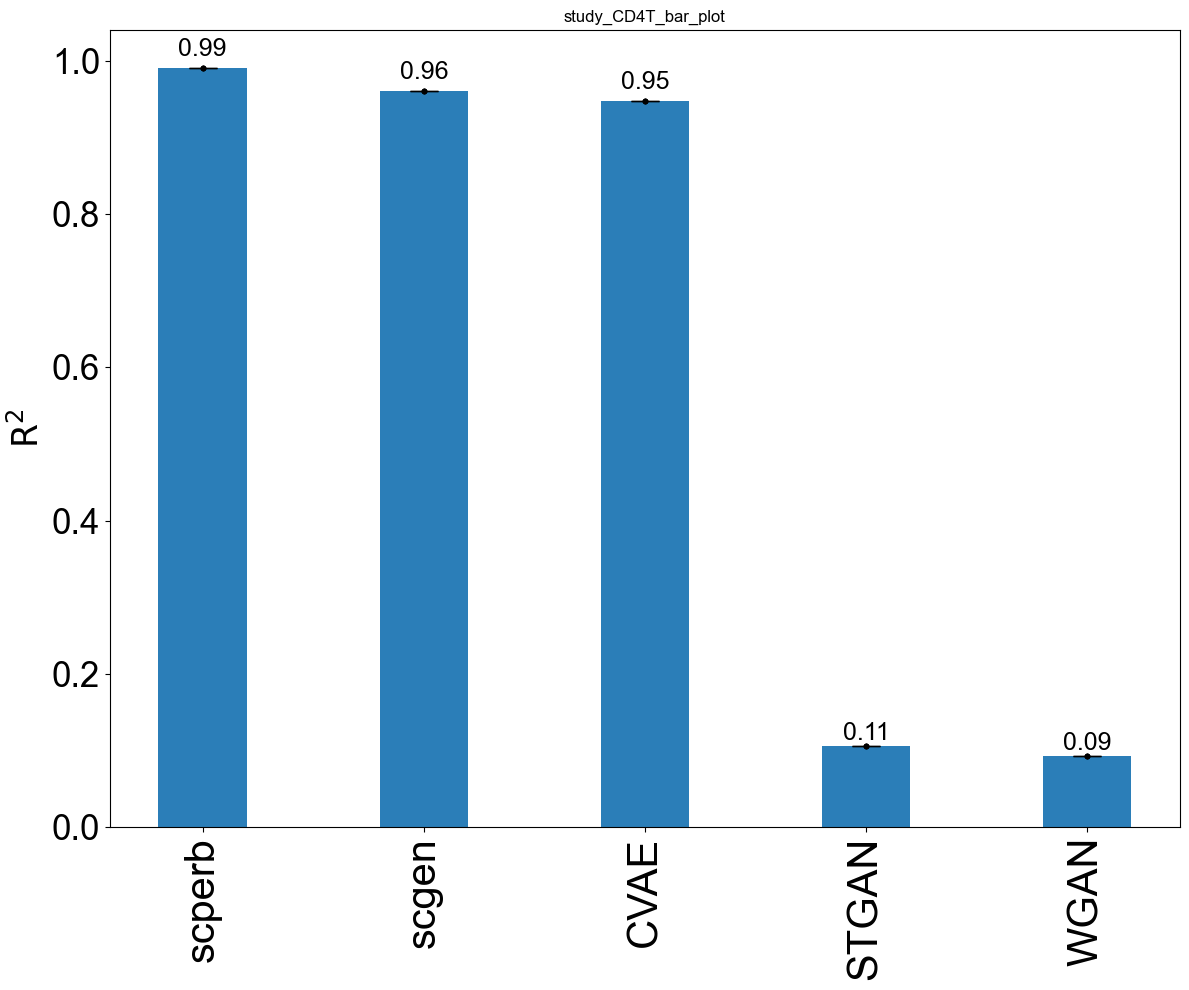

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

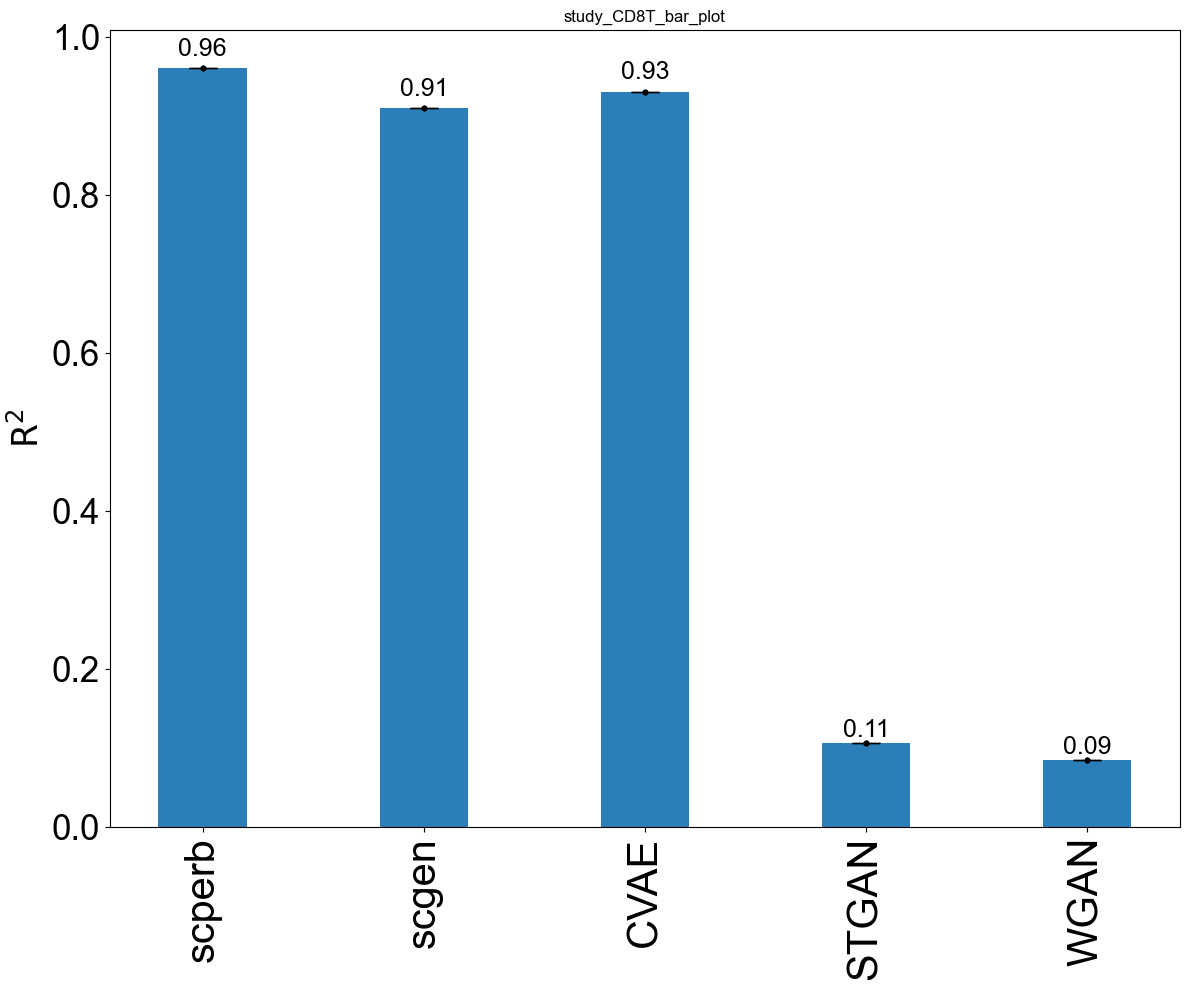

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

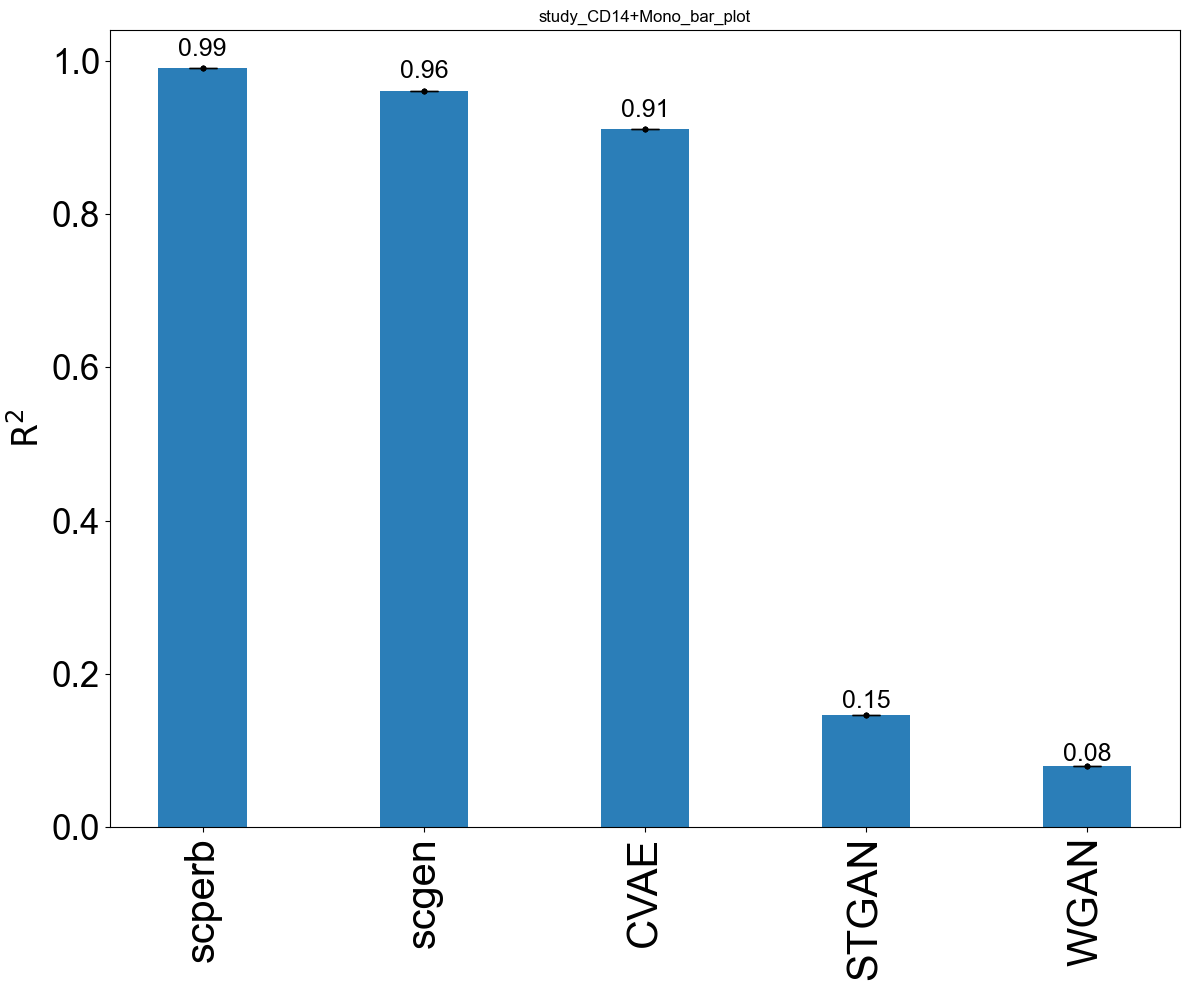

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

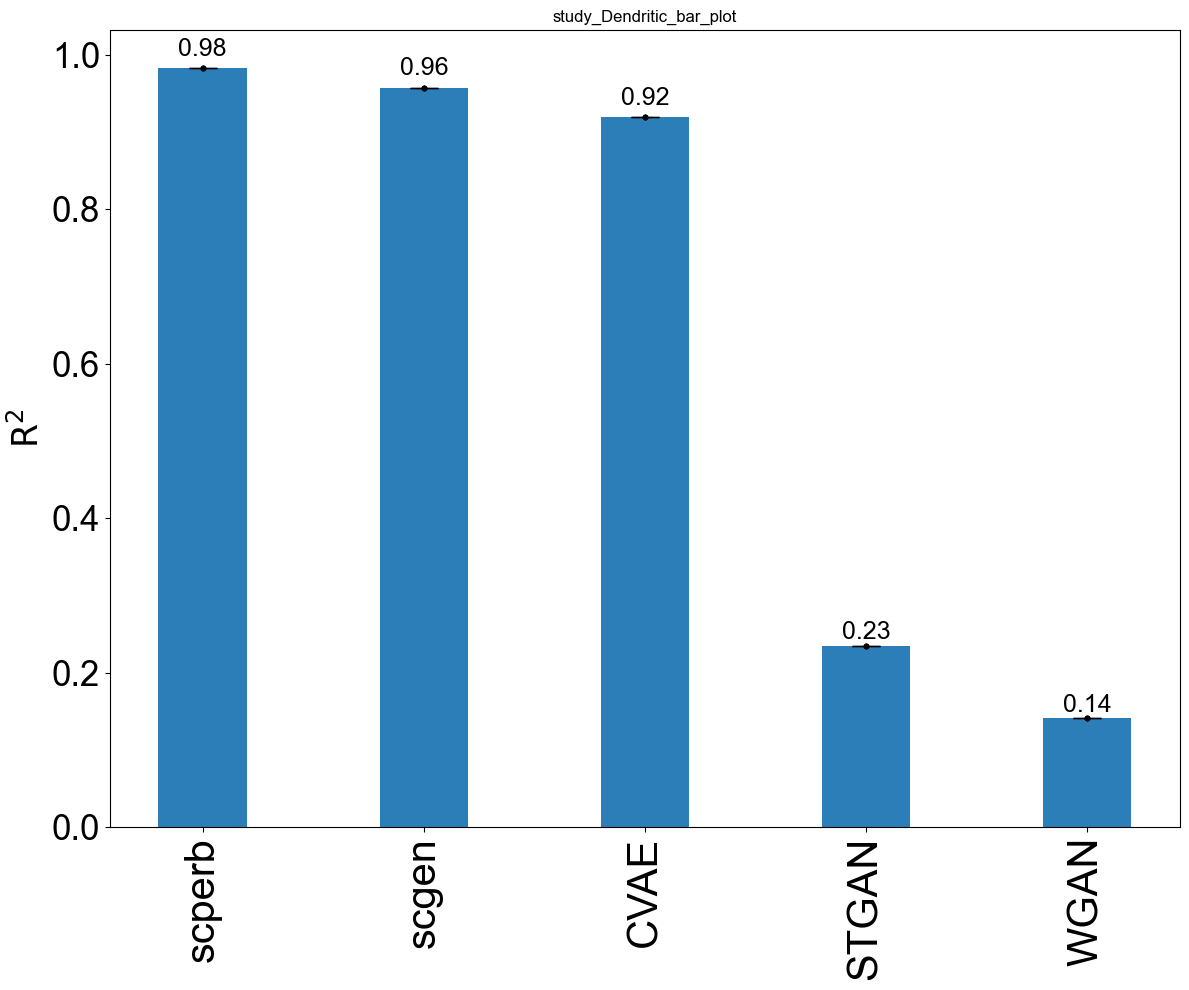

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

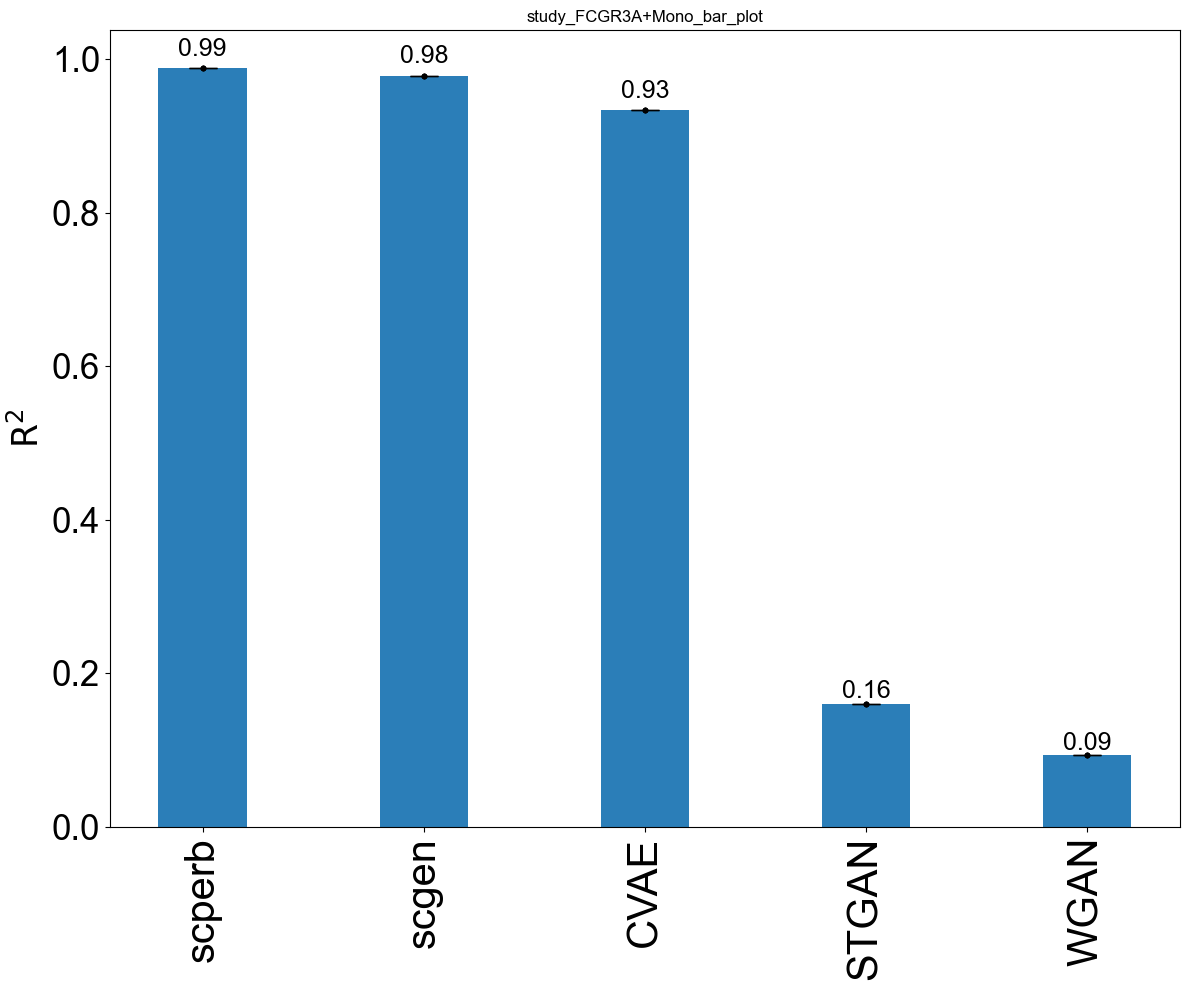

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/l

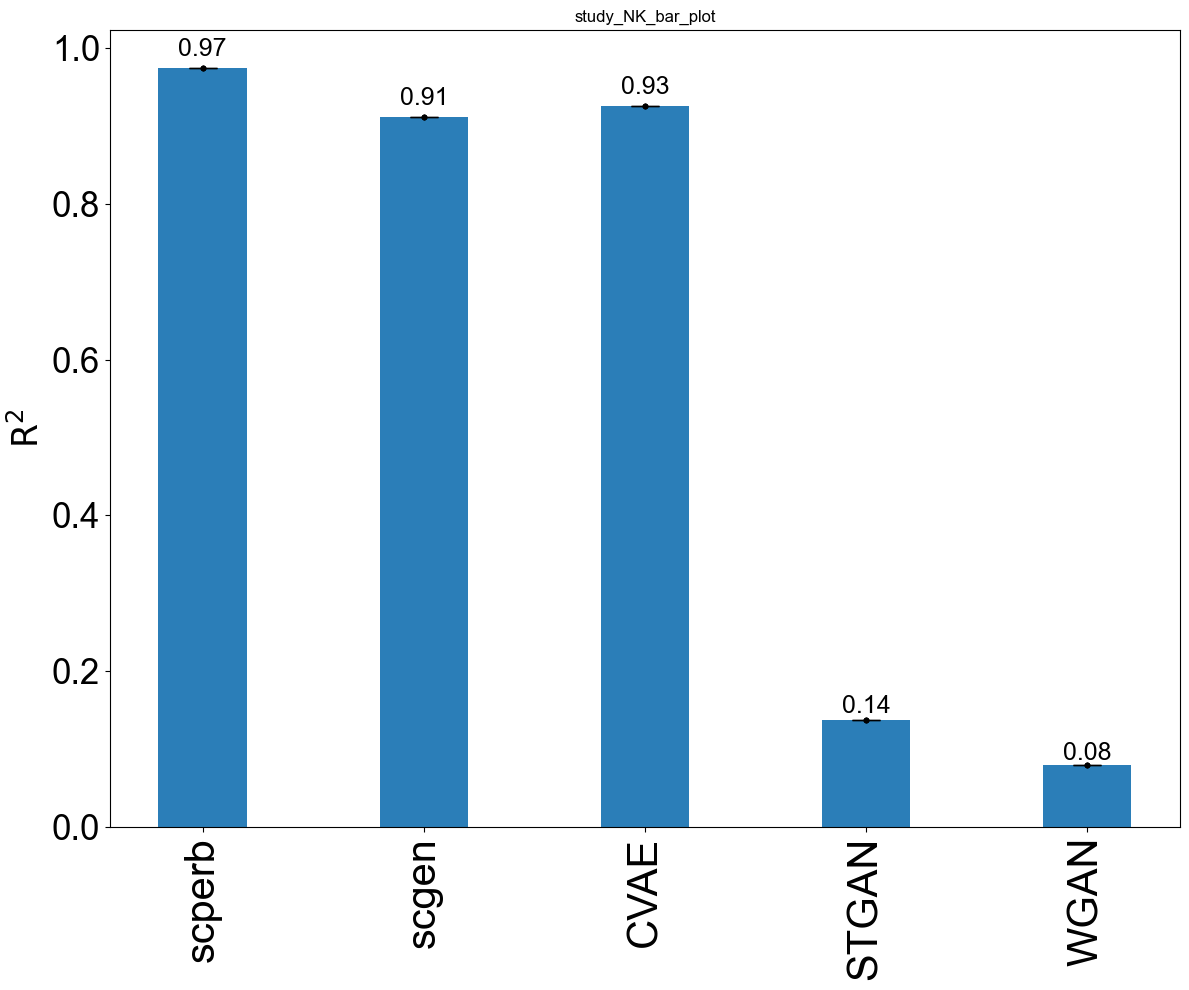

In [13]:
plot_all_cell_type_bar_garph("pbmc")
plot_all_cell_type_bar_garph("hpoly")
plot_all_cell_type_bar_garph("study")

In [14]:
def extract_cell_type_data(adata, cell_type, cell_type_key = 'cell_type'):
        return adata[adata.obs[cell_type_key] == cell_type] 

In [15]:
def get_condition_data(adata, condition_key = 'stimulated'):
        return adata[adata.obs['condition'] == condition_key] 

In [16]:
def get_genes(adata, stim_name = 'stimulated'):
    sc.tl.rank_genes_groups(adata, groupby="condition", method="wilcoxon")
    diff_genes = adata.uns["rank_genes_groups"]["names"][stim_name]
    return diff_genes

In [17]:
def create_df(adata, data_name, stim_data):
    adata_test = adata.concatenate(stim_data)
    sc.tl.rank_genes_groups(adata_test, groupby="condition", method="wilcoxon")
    adata_names = np.array(adata_test.uns["rank_genes_groups"]['names'].tolist())
    adata_pval = np.array(adata_test.uns["rank_genes_groups"]['pvals_adj'].tolist())
    ind = []
    for name in adata_names:
        ind.append(name[0])
    pval = []
    for pv in adata_pval:
        pval.append(pv[0])
    
    df = pd.DataFrame(index=ind)
    df[data_name + "_Pval"] = pval
    
    return df

In [18]:
def get_df(cell_type, name):
    all_data = get_cell_type_data(cell_type, name)
    scperb_df = create_df(get_condition_data(all_data, 'scperb'), "scperb", get_condition_data(all_data, 'real'))
    scgen_df = create_df(get_condition_data(all_data, 'scgen'), "scgen", get_condition_data(all_data, 'real'))
    cvae_df = create_df(get_condition_data(all_data, 'CVAE'), 'CVAE', get_condition_data(all_data, 'real'))
    stgan_df = create_df(get_condition_data(all_data, 'STGAN'), 'STGAN', get_condition_data(all_data, 'real'))
    wgan_df = create_df(get_condition_data(all_data, 'WGAN'), 'WGAN', get_condition_data(all_data, 'real'))
    all_df = scperb_df.join([scgen_df, cvae_df, stgan_df, wgan_df], how = 'left')
    return all_df

In [19]:
CD4T_pbmc_df = get_df("CD4T", "pbmc")
Goblet_df = get_df("Goblet", "hpoly")
CD4T_study_df = get_df("CD4T", "study")
CD4T_pbmc_df.to_csv()
print(CD4T_pbmc_df)
print(Goblet_df)
print(CD4T_study_df)

/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

                scperb_Pval     scgen_Pval     CVAE_Pval     STGAN_Pval  \
IRF7           2.549128e-06   1.536594e-05  1.817883e-07   4.595536e-99   
IFIT2          1.006640e-05   7.109822e-02  4.336508e-22   6.308081e-07   
GIMAP5         7.677658e-04   1.522224e-04  4.587165e-05   2.723203e-74   
CCR7           2.581494e-03   8.062478e-07  7.096507e-14  6.710970e-102   
SOD1           6.220584e-03   1.265692e-01  1.000000e+00   1.232572e-79   
...                     ...            ...           ...            ...   
AC022182.1    4.631252e-102   3.559588e-18  1.000000e+00   1.000000e+00   
C8orf44-SGK3  4.631252e-102   1.911564e-55  1.000000e+00   1.000000e+00   
XKR9          4.631252e-102   8.933041e-02  1.000000e+00   1.000000e+00   
HEY1          4.631252e-102   1.948637e-35  1.000000e+00   1.000000e+00   
RP4-798A10.7  4.631252e-102  7.280468e-100  1.000000e+00   1.000000e+00   

                  WGAN_Pval  
IRF7           5.303032e-10  
IFIT2          4.616008e-60  
GIMAP5   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [20]:
def plot_violin(use_gene, color_map, cell_type, name):
    models_violin = get_cell_type_data(cell_type, name)
    new_models = models_violin
    var_temp = models_violin.var_names.tolist()
    var_temp[var_temp.index(use_gene)] = use_gene + f" in {cell_type}"
    new_models.var_names = var_temp
    font = {'family' : 'Arial',
        'size'   : 30}

    sc.set_figure_params(fontsize=25)
    sns.set()
    matplotlib.rc('ytick', labelsize=14)
    matplotlib.rc('xtick', labelsize=14)
    sc.pl.violin(new_models, 
                 keys= use_gene + f" in {cell_type}", 
                 groupby="condition", 
                 show=True,
                 rotation = 90,
                 order=new_models.obs["condition"].unique().tolist(),
                 palette = color_map,
                 # save= f"{name}_{cell_type}_{use_gene}_violin_plot.pdf",
                 title = f"{name}_{cell_type}_{use_gene}_violin_plot",
                )

In [21]:
def get_all_violin_plot(data_name, gene_names, cell_type_name, df):
    for gene_name in gene_names[data_name]:    
        plot_violin(gene_name, color_map, cell_type_name, data_name)
        print(gene_name)
        names = df.loc[gene_name]
        print(names)

/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

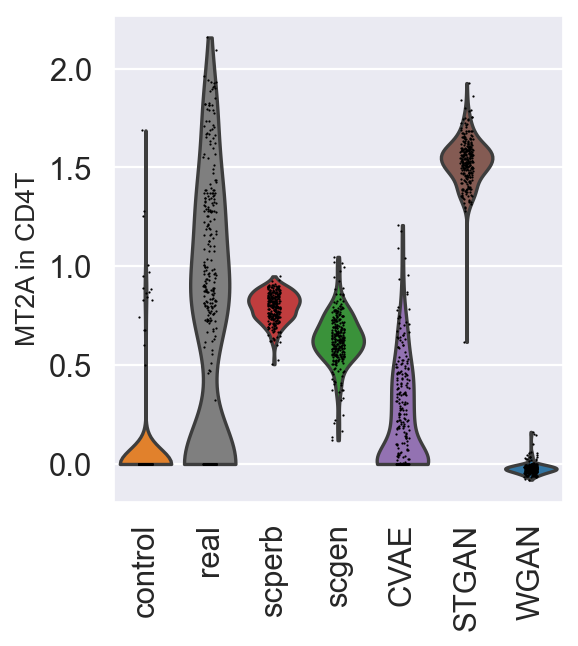

MT2A
scperb_Pval    8.785023e-01
scgen_Pval     5.808311e-04
CVAE_Pval      6.070734e-14
STGAN_Pval     5.045067e-59
WGAN_Pval      2.414616e-91
Name: MT2A, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

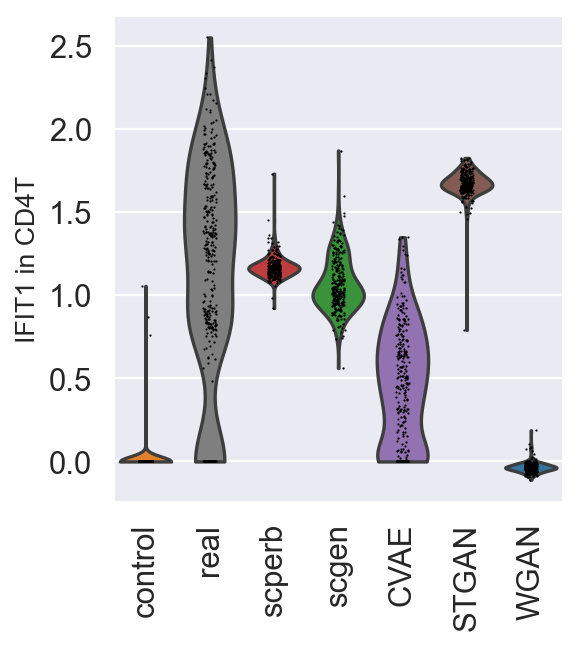

IFIT1
scperb_Pval    5.971105e-02
scgen_Pval     2.234554e-03
CVAE_Pval      6.046370e-37
STGAN_Pval     2.324690e-29
WGAN_Pval      2.969876e-99
Name: IFIT1, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

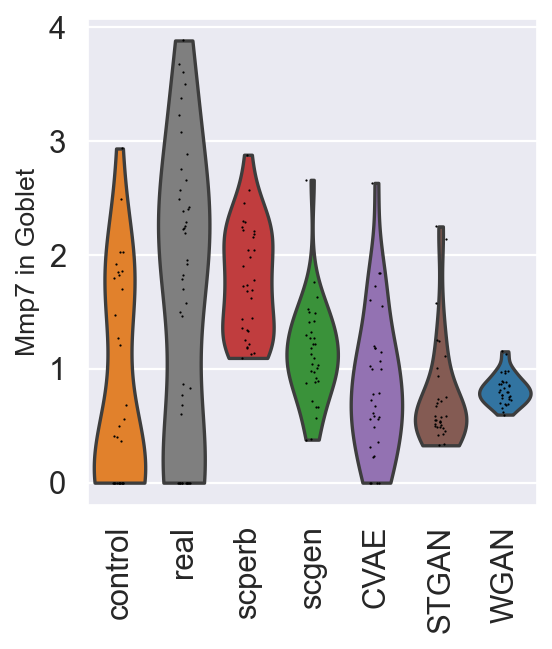

Mmp7
scperb_Pval    1.000000
scgen_Pval     0.095023
CVAE_Pval      0.485654
STGAN_Pval     0.013528
WGAN_Pval      0.016358
Name: Mmp7, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

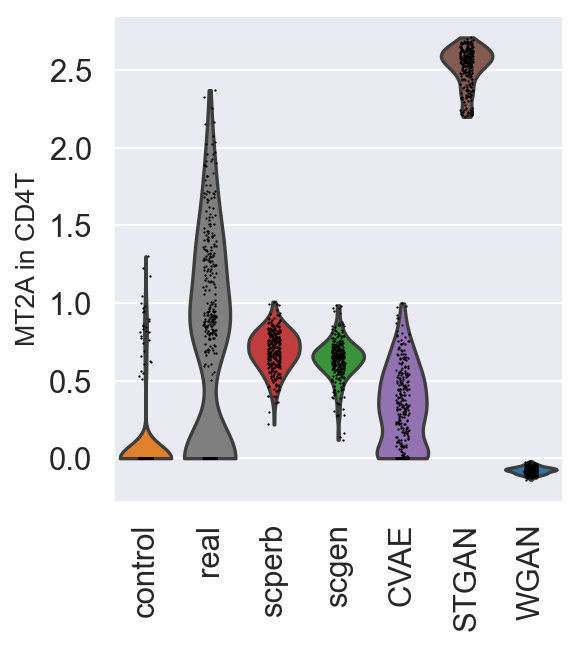

MT2A
scperb_Pval     1.358029e-03
scgen_Pval      2.974154e-05
CVAE_Pval       3.489555e-10
STGAN_Pval     2.114671e-109
WGAN_Pval      6.532369e-111
Name: MT2A, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

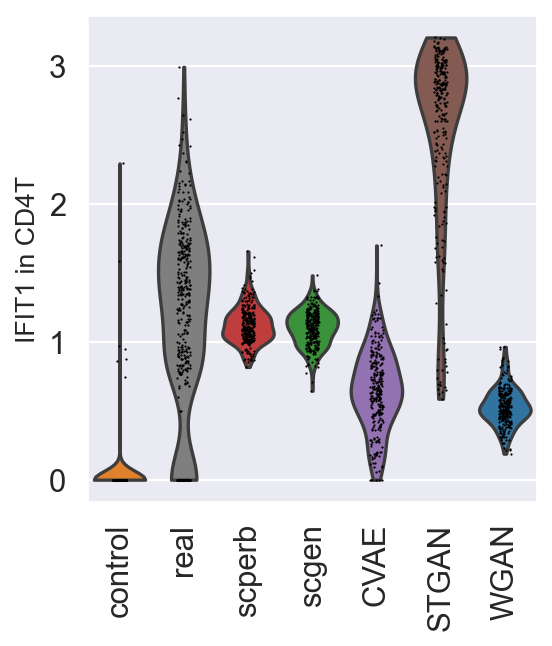

IFIT1
scperb_Pval    9.064641e-05
scgen_Pval     5.658550e-06
CVAE_Pval      3.945117e-35
STGAN_Pval     2.355747e-75
WGAN_Pval      1.600585e-49
Name: IFIT1, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

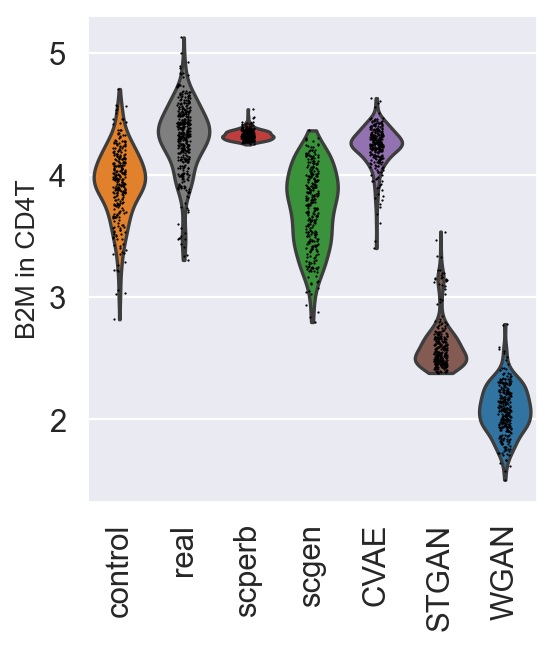

B2M
scperb_Pval     6.822636e-01
scgen_Pval      3.652155e-76
CVAE_Pval       1.208853e-06
STGAN_Pval     1.144636e-109
WGAN_Pval      6.532369e-111
Name: B2M, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

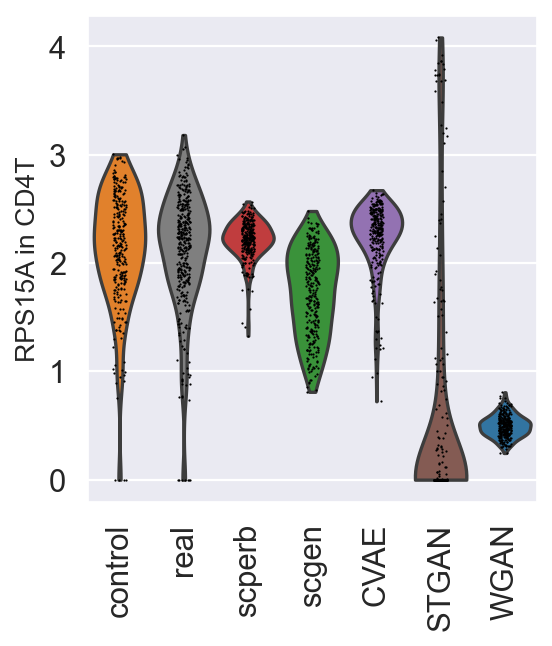

RPS15A
scperb_Pval     4.484661e-01
scgen_Pval      1.828389e-30
CVAE_Pval       2.728800e-02
STGAN_Pval      1.442739e-64
WGAN_Pval      3.111174e-103
Name: RPS15A, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

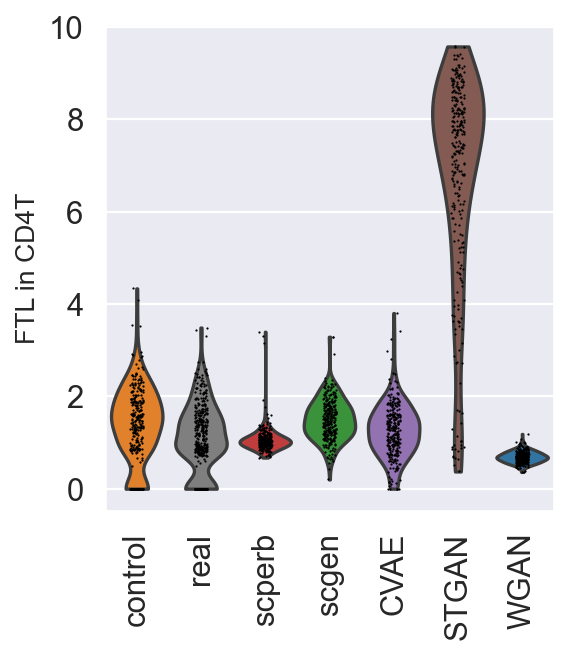

FTL
scperb_Pval    1.763158e-01
scgen_Pval     6.298732e-15
CVAE_Pval      3.075879e-02
STGAN_Pval     1.969209e-92
WGAN_Pval      2.013252e-31
Name: FTL, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

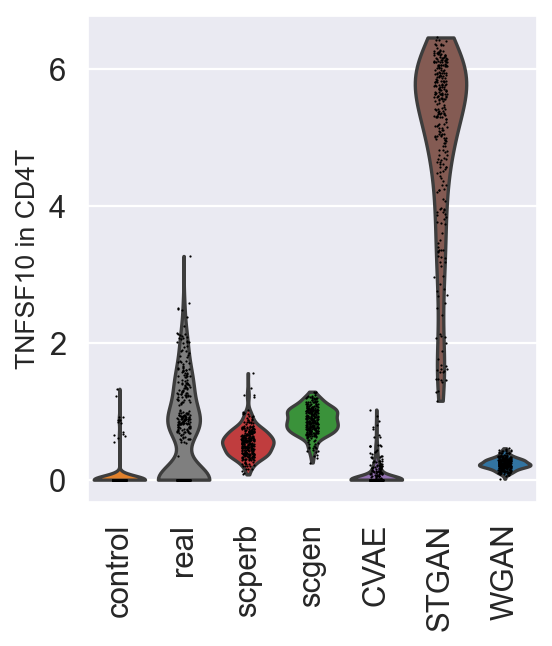

TNFSF10
scperb_Pval     1.473847e-01
scgen_Pval      5.959890e-06
CVAE_Pval       5.917595e-20
STGAN_Pval     3.195946e-106
WGAN_Pval       1.292805e-03
Name: TNFSF10, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

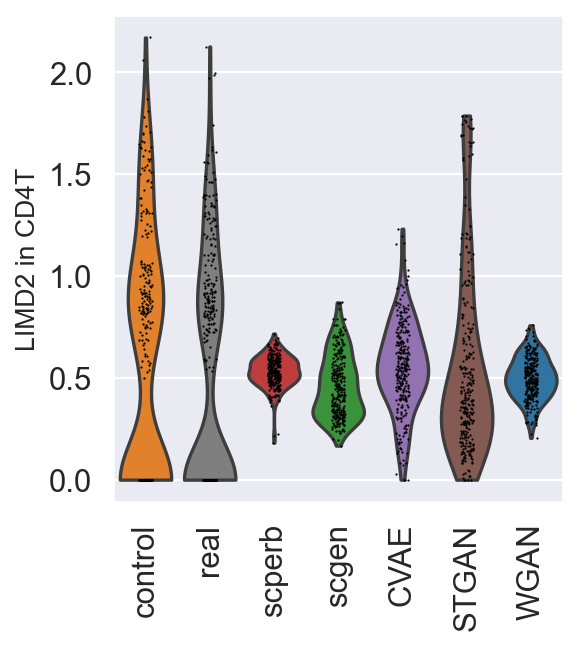

LIMD2
scperb_Pval    0.109307
scgen_Pval     0.083763
CVAE_Pval      0.029766
STGAN_Pval     0.000006
WGAN_Pval      0.115294
Name: LIMD2, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

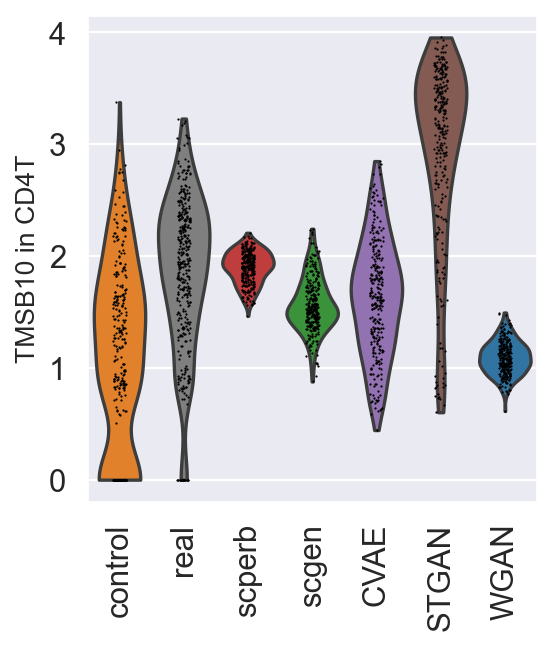

TMSB10
scperb_Pval    9.625972e-02
scgen_Pval     1.526425e-18
CVAE_Pval      2.641491e-08
STGAN_Pval     5.300292e-55
WGAN_Pval      7.375581e-57
Name: TMSB10, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

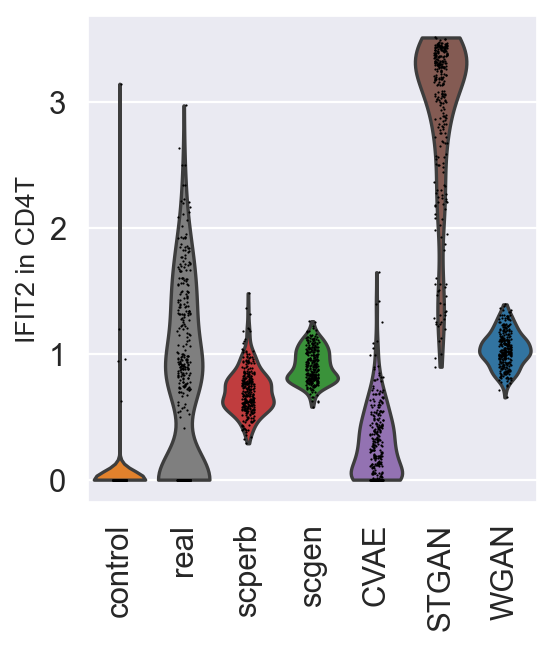

IFIT2
scperb_Pval    7.428659e-02
scgen_Pval     3.328290e-03
CVAE_Pval      1.634601e-09
STGAN_Pval     5.117679e-99
WGAN_Pval      2.408305e-10
Name: IFIT2, dtype: float64


/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scperb_pred.obs['condition'] = "scperb"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  scgen_pred.obs['condition'] = "scgen"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  CVAE_pred.obs['condition'] = "CVAE"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  STGAN_pred.obs['condition'] = "STGAN"
/var/folders/l4/t6jwt91d1_z5f9klb8v3wfdr0000gn/T/ipykernel_27459/2667992099.py:13: ImplicitModificationWa

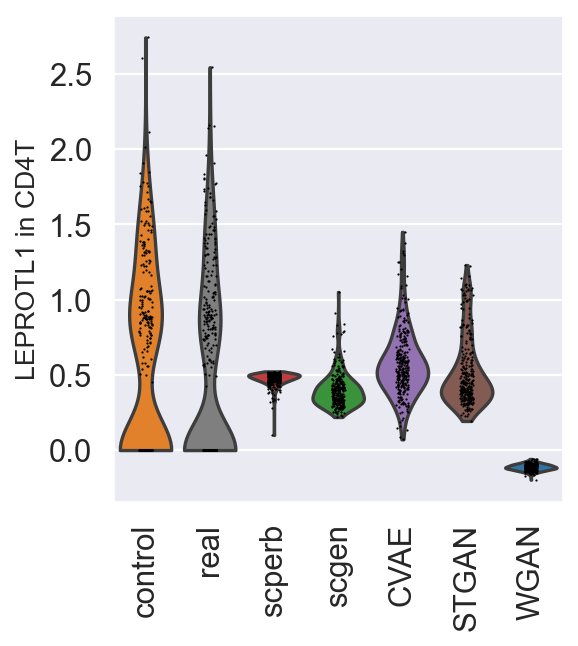

LEPROTL1
scperb_Pval     7.240273e-02
scgen_Pval      5.513041e-02
CVAE_Pval       9.328144e-04
STGAN_Pval      8.479456e-04
WGAN_Pval      6.532369e-111
Name: LEPROTL1, dtype: float64


In [22]:
# names = ['MT2A', 'S100A11', 'CD3D', 'BTG1', 'UBC', 'PFN1', 'SP100', 'IFIT1']
#colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
color_map = {'WGAN': "#1f77b4", 'scperb': '#D62728', 'control': '#ff7f0e', 'scgen': '#2ca02c', 'CVAE': '#9467bd', 'STGAN': '#8c564b', 'real': '#7f7f7f'}
gene_names = {
    "pbmc" : ['MT2A', 'IFIT1'],
    "hpoly" : ['Mmp7'],
    "study" : ['MT2A', 'IFIT1', 'B2M', 'RPS15A', 'FTL', 'TNFSF10', 'LIMD2', 'TMSB10', 'IFIT2', 'LEPROTL1'],
}
get_all_violin_plot("pbmc", gene_names, "CD4T", CD4T_pbmc_df)
get_all_violin_plot("hpoly", gene_names, "Goblet", Goblet_df)
get_all_violin_plot("study", gene_names, "CD4T", CD4T_study_df)